In [11]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [12]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    xc = np.reshape(xc, (num_data, shape_size))
    yc = np.reshape(yc, (num_data, shape_size))
    
    for j in range(num_data):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.6 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.6 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 2:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	7
Batch 3 has 	6
Batch 4 has 	17
Batch 5 has 	5
Batch 6 has 	14
Batch 7 has 	14
Batch 8 has 	40
Batch 9 has 	5
Batch 10 has 	14
Batch 11 has 	14
Batch 12 has 	40
Batch 13 has 	13
Batch 14 has 	37
Batch 15 has 	37
Batch 16 has 	106
Batch 17 has 	5
Batch 18 has 	14
Batch 19 has 	14
Batch 20 has 	40
Batch 21 has 	13
Batch 22 has 	37
Batch 23 has 	37
Batch 24 has 	106
Batch 25 has 	13
Batch 26 has 	37
Batch 27 has 	37
Batch 28 has 	106
Batch 29 has 	35
Batch 30 has 	100
Batch 31 has 	100
Batch 32 has 	287
Batch 33 has 	5
Batch 34 has 	14
Batch 35 has 	14
Batch 36 has 	40
Batch 37 has 	13
Batch 38 has 	37
Batch 39 has 	37
Batch 40 has 	106
Batch 41 has 	13
Batch 42 has 	37
Batch 43 has 	37
Batch 44 has 	106
Batch 45 has 	35
Batch 46 has 	100
Batch 47 has 	100
Batch 48 has 	287
Batch 49 has 	13
Batch 50 has 	37
Batch 51 has 	37
Batch 52 has 	106
Batch 53 has 	35
Batch 54 has 	100
Batch 55 has 	100
Batch 56 has 	287
Batch 57 has 	35
Batch 58 has 	100
Batch 59 has 	100
Batch 60 ha

In [13]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Train on 671 samples, validate on 168 samples
Epoch 1/1000
 - 1s - loss: 0.0475 - acc: 0.1535 - val_loss: 0.0340 - val_acc: 0.1786
Epoch 2/1000
 - 0s - loss: 0.0247 - acc: 0.1386 - val_loss: 0.0153 - val_acc: 0.1786
Epoch 3/1000
 - 0s - loss: 0.0112 - acc: 0.1505 - val_loss: 0.0089 - val_acc: 0.1964
Epoch 4/1000
 - 0s - loss: 0.0068 - acc: 0.1535 - val_loss: 0.0056 - val_acc: 0.1964
Epoch 5/1000
 - 0s - loss: 0.0044 - acc: 0.1505 - val_loss: 0.0042 - val_acc: 0.2083
Epoch 6/1000
 - 0s - loss: 0.0038 - acc: 0.1401 - val_loss: 0.0040 - val_acc: 0.1310
Epoch 7/1000
 - 0s - loss: 0.0037 - acc: 0.1386 - val_loss: 0.0039 - val_acc: 0.1310
Epoch 8/1000
 - 0s - loss: 0.0036 - acc: 0.1446 - val_loss: 0.0039 - val_acc: 0.1905
Epoch 9/1000
 - 0s - loss: 0.0036 - acc: 0.1535 - val_loss: 0.0038 - val_acc: 0.2440
Epoch 10/1000
 - 0s - loss: 0.0036 - acc: 0.1714 - val_loss: 0.0038 - val_acc: 0.1964
Epoch 11/1000
 - 0s - loss: 0.0036 - acc: 0.1475 - val_loss: 0.0038 - val_acc: 0.1548
Epoch 12/1000
 - 

Epoch 96/1000
 - 0s - loss: 0.0011 - acc: 0.4620 - val_loss: 0.0014 - val_acc: 0.3810
Epoch 97/1000
 - 0s - loss: 0.0011 - acc: 0.4918 - val_loss: 0.0015 - val_acc: 0.3929
Epoch 98/1000
 - 0s - loss: 0.0010 - acc: 0.4635 - val_loss: 0.0017 - val_acc: 0.3988
Epoch 99/1000
 - 0s - loss: 0.0011 - acc: 0.4620 - val_loss: 0.0017 - val_acc: 0.3929
Epoch 100/1000
 - 0s - loss: 0.0011 - acc: 0.4903 - val_loss: 0.0015 - val_acc: 0.4286
Epoch 101/1000
 - 0s - loss: 9.7835e-04 - acc: 0.4888 - val_loss: 0.0014 - val_acc: 0.4583
Epoch 102/1000
 - 0s - loss: 0.0010 - acc: 0.4933 - val_loss: 0.0014 - val_acc: 0.4464
Epoch 103/1000
 - 0s - loss: 9.9682e-04 - acc: 0.4769 - val_loss: 0.0016 - val_acc: 0.4048
Epoch 104/1000
 - 0s - loss: 9.9732e-04 - acc: 0.4665 - val_loss: 0.0015 - val_acc: 0.4405
Epoch 105/1000
 - 0s - loss: 9.6686e-04 - acc: 0.5007 - val_loss: 0.0016 - val_acc: 0.4107
Epoch 106/1000
 - 0s - loss: 0.0010 - acc: 0.4873 - val_loss: 0.0014 - val_acc: 0.3869
Epoch 107/1000
 - 0s - loss: 0.

Epoch 187/1000
 - 0s - loss: 5.5504e-04 - acc: 0.6006 - val_loss: 0.0013 - val_acc: 0.5179
Epoch 188/1000
 - 0s - loss: 5.4410e-04 - acc: 0.5723 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 189/1000
 - 0s - loss: 5.1796e-04 - acc: 0.5946 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 190/1000
 - 0s - loss: 5.2047e-04 - acc: 0.5797 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 191/1000
 - 0s - loss: 5.2417e-04 - acc: 0.5902 - val_loss: 0.0014 - val_acc: 0.5060
Epoch 192/1000
 - 0s - loss: 5.0561e-04 - acc: 0.5872 - val_loss: 0.0013 - val_acc: 0.4881
Epoch 193/1000
 - 0s - loss: 4.6038e-04 - acc: 0.5887 - val_loss: 0.0014 - val_acc: 0.4762
Epoch 194/1000
 - 0s - loss: 5.4754e-04 - acc: 0.5589 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 195/1000
 - 0s - loss: 5.5338e-04 - acc: 0.5827 - val_loss: 0.0014 - val_acc: 0.4762
Epoch 196/1000
 - 0s - loss: 5.1164e-04 - acc: 0.5455 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 197/1000
 - 0s - loss: 5.3482e-04 - acc: 0.5872 - val_loss: 0.0013 - val_acc: 0.4940

 - 0s - loss: 2.6786e-04 - acc: 0.6110 - val_loss: 0.0012 - val_acc: 0.4583
Epoch 278/1000
 - 0s - loss: 2.6550e-04 - acc: 0.6274 - val_loss: 0.0012 - val_acc: 0.5536
Epoch 279/1000
 - 0s - loss: 2.6433e-04 - acc: 0.6244 - val_loss: 0.0013 - val_acc: 0.4940
Epoch 280/1000
 - 0s - loss: 2.8155e-04 - acc: 0.6170 - val_loss: 0.0012 - val_acc: 0.4881
Epoch 281/1000
 - 0s - loss: 2.7513e-04 - acc: 0.6080 - val_loss: 0.0013 - val_acc: 0.4345
Epoch 282/1000
 - 0s - loss: 3.0624e-04 - acc: 0.6140 - val_loss: 0.0013 - val_acc: 0.4345
Epoch 283/1000
 - 0s - loss: 3.3485e-04 - acc: 0.6006 - val_loss: 0.0014 - val_acc: 0.4762
Epoch 284/1000
 - 0s - loss: 3.0946e-04 - acc: 0.6408 - val_loss: 0.0013 - val_acc: 0.4762
Epoch 285/1000
 - 0s - loss: 2.8821e-04 - acc: 0.6319 - val_loss: 0.0013 - val_acc: 0.4226
Epoch 286/1000
 - 0s - loss: 3.4207e-04 - acc: 0.6095 - val_loss: 0.0014 - val_acc: 0.5476
Epoch 287/1000
 - 0s - loss: 3.5893e-04 - acc: 0.6036 - val_loss: 0.0013 - val_acc: 0.5238
Epoch 288/1000

Epoch 368/1000
 - 0s - loss: 2.5394e-04 - acc: 0.6438 - val_loss: 0.0013 - val_acc: 0.5417
Epoch 369/1000
 - 0s - loss: 2.2713e-04 - acc: 0.6066 - val_loss: 0.0013 - val_acc: 0.5060
Epoch 370/1000
 - 0s - loss: 2.1677e-04 - acc: 0.6438 - val_loss: 0.0013 - val_acc: 0.5357
Epoch 371/1000
 - 0s - loss: 2.0962e-04 - acc: 0.6364 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 372/1000
 - 0s - loss: 1.7923e-04 - acc: 0.6513 - val_loss: 0.0013 - val_acc: 0.5595
Epoch 373/1000
 - 0s - loss: 1.6532e-04 - acc: 0.6319 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 374/1000
 - 0s - loss: 1.4939e-04 - acc: 0.6468 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 375/1000
 - 0s - loss: 1.4459e-04 - acc: 0.6572 - val_loss: 0.0012 - val_acc: 0.4881
Epoch 376/1000
 - 0s - loss: 1.3310e-04 - acc: 0.6349 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 377/1000
 - 0s - loss: 1.4507e-04 - acc: 0.6215 - val_loss: 0.0012 - val_acc: 0.5238
Epoch 378/1000
 - 0s - loss: 1.6038e-04 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5000

Epoch 459/1000
 - 0s - loss: 2.2921e-04 - acc: 0.6453 - val_loss: 0.0013 - val_acc: 0.5357
Epoch 460/1000
 - 0s - loss: 2.9927e-04 - acc: 0.6155 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 461/1000
 - 0s - loss: 2.0587e-04 - acc: 0.6259 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 462/1000
 - 0s - loss: 2.0430e-04 - acc: 0.6393 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 463/1000
 - 0s - loss: 1.7794e-04 - acc: 0.6468 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 464/1000
 - 0s - loss: 1.3143e-04 - acc: 0.6572 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 465/1000
 - 0s - loss: 1.1141e-04 - acc: 0.6528 - val_loss: 0.0012 - val_acc: 0.5595
Epoch 466/1000
 - 0s - loss: 1.1481e-04 - acc: 0.6647 - val_loss: 0.0012 - val_acc: 0.5060
Epoch 467/1000
 - 0s - loss: 1.2226e-04 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.4821
Epoch 468/1000
 - 0s - loss: 1.1123e-04 - acc: 0.6244 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 469/1000
 - 0s - loss: 1.0083e-04 - acc: 0.6557 - val_loss: 0.0012 - val_acc: 0.5179

 - 0s - loss: 1.9922e-04 - acc: 0.6155 - val_loss: 0.0012 - val_acc: 0.4762
Epoch 550/1000
 - 0s - loss: 2.2654e-04 - acc: 0.6200 - val_loss: 0.0012 - val_acc: 0.4762
Epoch 551/1000
 - 0s - loss: 1.4916e-04 - acc: 0.6319 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 552/1000
 - 0s - loss: 1.1230e-04 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 553/1000
 - 0s - loss: 9.5915e-05 - acc: 0.6677 - val_loss: 0.0012 - val_acc: 0.5060
Epoch 554/1000
 - 0s - loss: 7.8036e-05 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5238
Epoch 555/1000
 - 0s - loss: 6.9656e-05 - acc: 0.6781 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 556/1000
 - 0s - loss: 6.2143e-05 - acc: 0.6692 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 557/1000
 - 0s - loss: 6.7483e-05 - acc: 0.6483 - val_loss: 0.0011 - val_acc: 0.5238
Epoch 558/1000
 - 0s - loss: 6.1630e-05 - acc: 0.6885 - val_loss: 0.0011 - val_acc: 0.5476
Epoch 559/1000
 - 0s - loss: 5.9317e-05 - acc: 0.6870 - val_loss: 0.0012 - val_acc: 0.5238
Epoch 560/1000

Epoch 640/1000
 - 0s - loss: 4.7304e-05 - acc: 0.6557 - val_loss: 0.0011 - val_acc: 0.5060
Epoch 641/1000
 - 0s - loss: 4.4155e-05 - acc: 0.6498 - val_loss: 0.0011 - val_acc: 0.5060
Epoch 642/1000
 - 0s - loss: 5.1303e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 643/1000
 - 0s - loss: 5.4416e-05 - acc: 0.6408 - val_loss: 0.0012 - val_acc: 0.4940
Epoch 644/1000
 - 0s - loss: 6.0317e-05 - acc: 0.6706 - val_loss: 0.0012 - val_acc: 0.5060
Epoch 645/1000
 - 0s - loss: 6.1385e-05 - acc: 0.6259 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 646/1000
 - 0s - loss: 4.9826e-05 - acc: 0.6542 - val_loss: 0.0011 - val_acc: 0.5179
Epoch 647/1000
 - 0s - loss: 3.7749e-05 - acc: 0.6557 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 648/1000
 - 0s - loss: 4.4956e-05 - acc: 0.6587 - val_loss: 0.0012 - val_acc: 0.5060
Epoch 649/1000
 - 0s - loss: 6.5511e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5119
Epoch 650/1000
 - 0s - loss: 7.6820e-05 - acc: 0.6721 - val_loss: 0.0011 - val_acc: 0.4702

 - 0s - loss: 3.8205e-05 - acc: 0.6632 - val_loss: 0.0011 - val_acc: 0.5298
Epoch 731/1000
 - 0s - loss: 4.0007e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5238
Epoch 732/1000
 - 0s - loss: 4.0510e-05 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5476
Epoch 733/1000
 - 0s - loss: 4.4051e-05 - acc: 0.6513 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 734/1000
 - 0s - loss: 3.4342e-05 - acc: 0.6572 - val_loss: 0.0012 - val_acc: 0.5238
Epoch 735/1000
 - 0s - loss: 3.6279e-05 - acc: 0.6617 - val_loss: 0.0012 - val_acc: 0.5655
Epoch 736/1000
 - 0s - loss: 6.7386e-05 - acc: 0.6557 - val_loss: 0.0012 - val_acc: 0.4940
Epoch 737/1000
 - 0s - loss: 7.5378e-05 - acc: 0.6766 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 738/1000
 - 0s - loss: 5.5125e-05 - acc: 0.6736 - val_loss: 0.0012 - val_acc: 0.4821
Epoch 739/1000
 - 0s - loss: 5.5199e-05 - acc: 0.6736 - val_loss: 0.0012 - val_acc: 0.4762
Epoch 740/1000
 - 0s - loss: 4.7950e-05 - acc: 0.6721 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 741/1000

Epoch 821/1000
 - 0s - loss: 2.4673e-05 - acc: 0.6781 - val_loss: 0.0011 - val_acc: 0.5357
Epoch 822/1000
 - 0s - loss: 2.7665e-05 - acc: 0.6542 - val_loss: 0.0011 - val_acc: 0.5357
Epoch 823/1000
 - 0s - loss: 2.6843e-05 - acc: 0.6587 - val_loss: 0.0011 - val_acc: 0.5536
Epoch 824/1000
 - 0s - loss: 2.5766e-05 - acc: 0.6826 - val_loss: 0.0011 - val_acc: 0.5417
Epoch 825/1000
 - 0s - loss: 2.7650e-05 - acc: 0.6528 - val_loss: 0.0011 - val_acc: 0.4940
Epoch 826/1000
 - 0s - loss: 2.7082e-05 - acc: 0.6885 - val_loss: 0.0011 - val_acc: 0.5060
Epoch 827/1000
 - 0s - loss: 3.3637e-05 - acc: 0.6408 - val_loss: 0.0011 - val_acc: 0.5298
Epoch 828/1000
 - 0s - loss: 3.1519e-05 - acc: 0.6781 - val_loss: 0.0011 - val_acc: 0.5119
Epoch 829/1000
 - 0s - loss: 2.9361e-05 - acc: 0.6602 - val_loss: 0.0011 - val_acc: 0.5119
Epoch 830/1000
 - 0s - loss: 2.4779e-05 - acc: 0.6751 - val_loss: 0.0011 - val_acc: 0.5298
Epoch 831/1000
 - 0s - loss: 3.6631e-05 - acc: 0.6408 - val_loss: 0.0011 - val_acc: 0.4702

 - 0s - loss: 2.7881e-05 - acc: 0.6751 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 912/1000
 - 0s - loss: 2.4718e-05 - acc: 0.6408 - val_loss: 0.0011 - val_acc: 0.5357
Epoch 913/1000
 - 0s - loss: 4.3037e-05 - acc: 0.6811 - val_loss: 0.0012 - val_acc: 0.4881
Epoch 914/1000
 - 0s - loss: 4.3646e-05 - acc: 0.6513 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 915/1000
 - 0s - loss: 3.7120e-05 - acc: 0.6751 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 916/1000
 - 0s - loss: 2.5818e-05 - acc: 0.6587 - val_loss: 0.0011 - val_acc: 0.5655
Epoch 917/1000
 - 0s - loss: 2.1924e-05 - acc: 0.6647 - val_loss: 0.0011 - val_acc: 0.5298
Epoch 918/1000
 - 0s - loss: 3.3087e-05 - acc: 0.6528 - val_loss: 0.0012 - val_acc: 0.5119
Epoch 919/1000
 - 0s - loss: 5.5679e-05 - acc: 0.6692 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 920/1000
 - 0s - loss: 5.6552e-05 - acc: 0.6721 - val_loss: 0.0011 - val_acc: 0.5417
Epoch 921/1000
 - 0s - loss: 9.1740e-05 - acc: 0.6393 - val_loss: 0.0012 - val_acc: 0.4464
Epoch 922/1000

168/168 [==============================] - 0s 112us/step
[1.979761196604828e-05, 0.6438151982608744]
[0.001128985385072329, 0.5238095277122089]


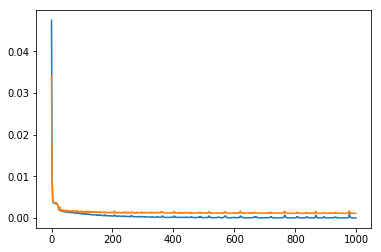

In [14]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.2        0.3        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.27506706 0.3008455  0.2077947  0.21394753 0.26430213 0.29342115]]



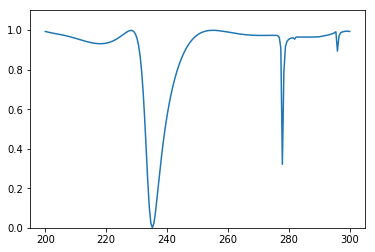

Test 1
True shape: [0.1       0.2       0.2       0.3       0.3       0.2963065]
Predicted shape: [[0.10141459 0.20454657 0.20159754 0.30052036 0.29552215 0.2977123 ]]



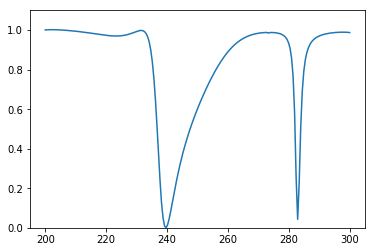

Test 2
True shape: [0.2       0.3       0.2370452 0.2       0.3       0.2963065]
Predicted shape: [[0.2504233  0.20428908 0.26477242 0.24439234 0.3152173  0.24343295]]



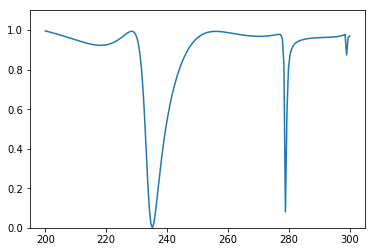

Test 3
True shape: [0.1       0.2       0.2       0.2370452 0.3       0.3      ]
Predicted shape: [[0.1005176  0.20757574 0.20482922 0.23936418 0.30443627 0.29565915]]



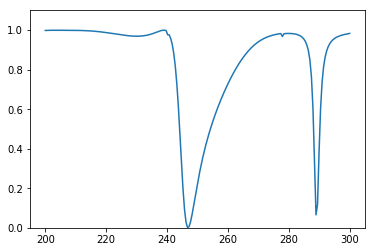

Test 4
True shape: [0.19753767 0.2        0.2370452  0.3        0.28887347 0.28531695]
Predicted shape: [[0.22410426 0.24985251 0.21760774 0.23487708 0.3075231  0.30578277]]



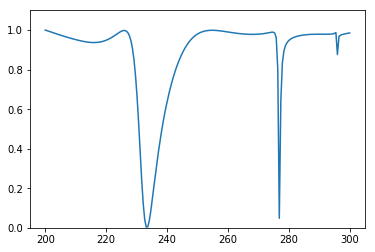

Test 5
True shape: [0.2        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.19770998 0.2004458  0.21724397 0.24869412 0.29693446 0.39733523]]



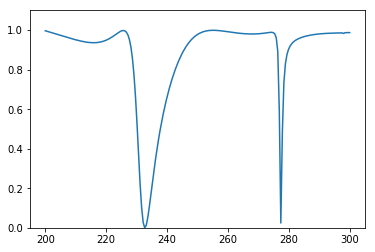

Test 6
True shape: [0.2        0.3        0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.19410187 0.2959304  0.19794554 0.19990295 0.19832389 0.2015259 ]]



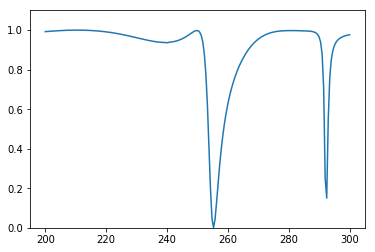

Test 7
True shape: [0.3 0.3 0.2 0.3 0.2 0.2]
Predicted shape: [[0.29541534 0.27043158 0.21659118 0.28717774 0.20891218 0.20095946]]



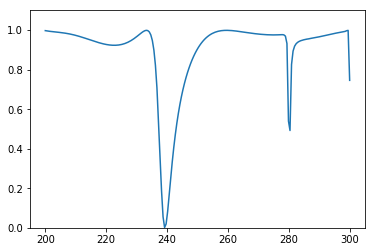

Test 8
True shape: [0.3        0.2370452  0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.20043787 0.1249885  0.20134068 0.23217478 0.29540062 0.20020871]]



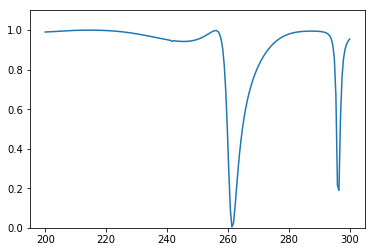

Test 9
True shape: [0.3        0.3        0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.28666046 0.29079634 0.2079384  0.1127845  0.12635851 0.18798569]]



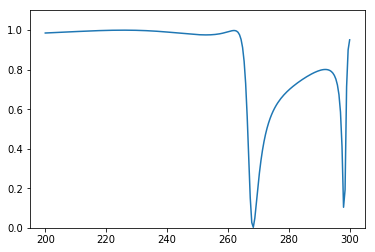

Test 10
True shape: [0.4        0.3        0.25051498 0.21968701 0.2        0.19753767]
Predicted shape: [[0.37244368 0.29786184 0.26989746 0.21956861 0.20636353 0.19356628]]



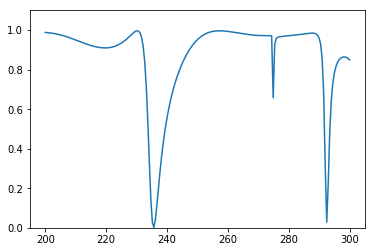

Test 11
True shape: [0.2 0.3 0.2 0.2 0.3 0.3]
Predicted shape: [[0.20075071 0.2909655  0.19295043 0.20706484 0.30858457 0.30089396]]



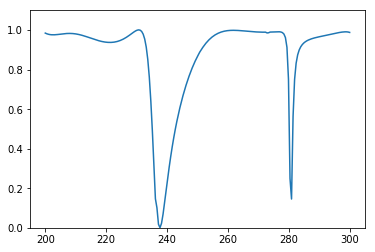

Test 12
True shape: [0.3        0.292613   0.292613   0.3        0.28887347 0.28531695]
Predicted shape: [[0.28745168 0.29305366 0.2930042  0.2970252  0.2965526  0.29336572]]



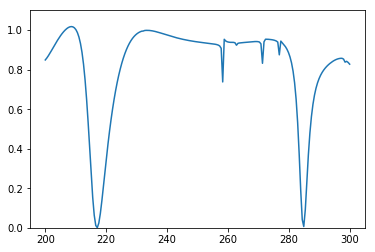

Test 13
True shape: [0.3        0.2        0.19753767 0.2        0.3        0.4       ]
Predicted shape: [[0.16209617 0.16174889 0.20346746 0.27402872 0.31165528 0.40354106]]



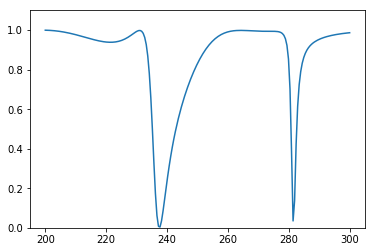

Test 14
True shape: [0.4        0.3        0.2370452  0.2        0.19753767 0.2       ]
Predicted shape: [[0.40359756 0.30394745 0.24129787 0.18757874 0.20434856 0.20660627]]



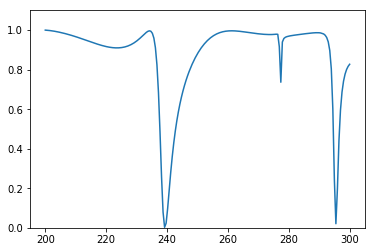

Test 15
True shape: [0.1        0.2        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.1067754  0.20763323 0.2954331  0.29153216 0.2009638  0.20006193]]



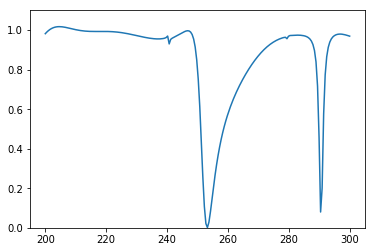

Test 16
True shape: [0.2        0.19753767 0.2        0.2        0.3        0.4       ]
Predicted shape: [[0.19781658 0.20464563 0.20034385 0.19961545 0.3021749  0.40237424]]



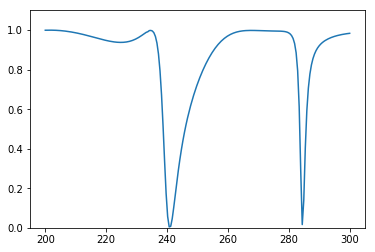

Test 17
True shape: [0.2       0.2370452 0.3       0.3       0.2       0.3      ]
Predicted shape: [[0.2990594  0.25954753 0.22483677 0.20334503 0.29351592 0.29153916]]



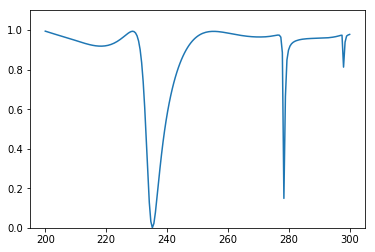

Test 18
True shape: [0.2        0.19753767 0.2        0.3        0.2370452  0.2       ]
Predicted shape: [[0.18681172 0.18979439 0.19845983 0.29973477 0.23502046 0.2006607 ]]



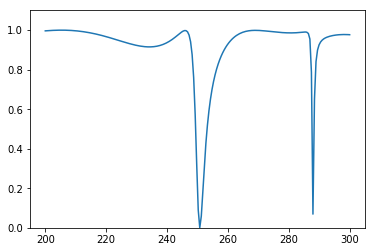

Test 19
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.3      ]
Predicted shape: [[0.19767356 0.3197327  0.22493193 0.21329382 0.2428746  0.28226775]]



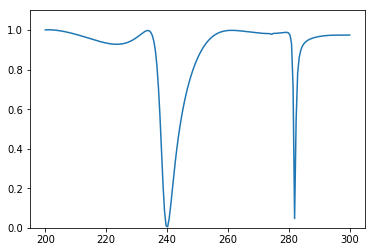

Test 20
True shape: [0.3        0.3        0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.27093646 0.25603846 0.18538228 0.20992959 0.20274724 0.16978064]]



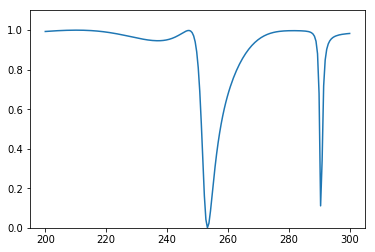

Test 21
True shape: [0.28531695 0.28887347 0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.30201375 0.28549588 0.2666567  0.21152356 0.20164028 0.19266409]]



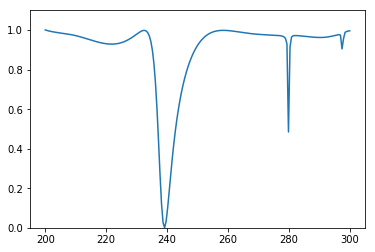

Test 22
True shape: [0.2 0.3 0.2 0.2 0.2 0.2]
Predicted shape: [[0.221578   0.29741603 0.2002942  0.21054238 0.18837425 0.22610699]]



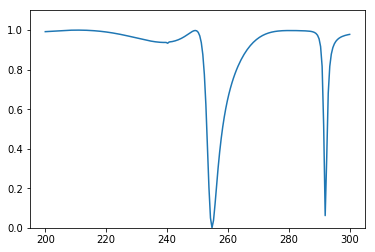

Test 23
True shape: [0.4      0.338636 0.3      0.3      0.2      0.1     ]
Predicted shape: [[0.39800122 0.36824852 0.28867683 0.20838276 0.2039217  0.21724437]]



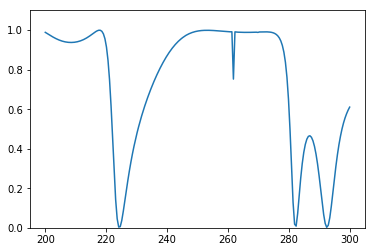

Test 24
True shape: [0.3 0.2 0.3 0.2 0.1 0.2]
Predicted shape: [[0.29836702 0.20976478 0.2928417  0.19277558 0.13537428 0.09786929]]



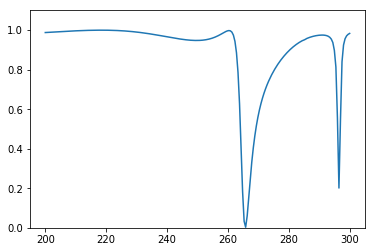

Test 25
True shape: [0.3        0.3        0.2        0.13169178 0.1        0.09876883]
Predicted shape: [[0.2996573  0.30093408 0.19768772 0.14243111 0.10301207 0.09439801]]



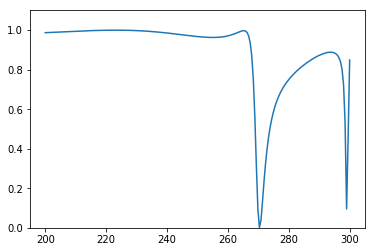

Test 26
True shape: [0.3 0.3 0.2 0.1 0.2 0.2]
Predicted shape: [[0.29700652 0.2972086  0.20162675 0.1082975  0.19248794 0.20156845]]



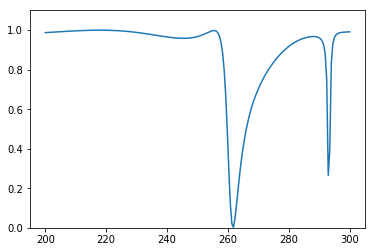

Test 27
True shape: [0.2 0.3 0.3 0.2 0.2 0.1]
Predicted shape: [[0.29951698 0.29525065 0.23371819 0.21260473 0.19474834 0.13020717]]



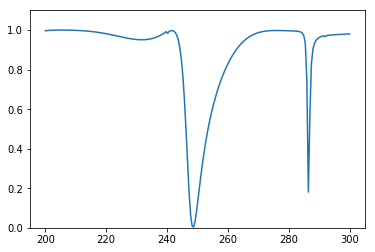

Test 28
True shape: [0.4 0.3 0.3 0.2 0.2 0.1]
Predicted shape: [[0.33051836 0.3056144  0.24204034 0.1996507  0.23673767 0.18020523]]



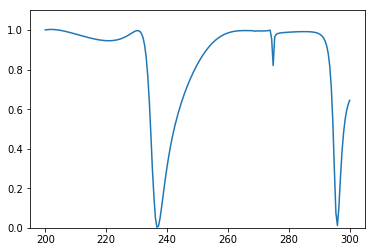

Test 29
True shape: [0.2       0.2       0.2370452 0.3       0.3       0.2      ]
Predicted shape: [[0.25267088 0.19625625 0.20930901 0.3027566  0.31396973 0.19905159]]



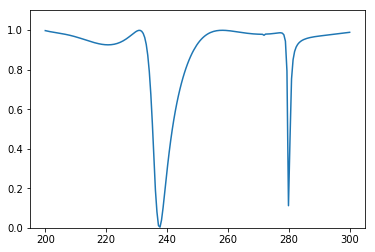

Test 30
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.1887995  0.19454351 0.19639659 0.3040447  0.19849588 0.20646617]]



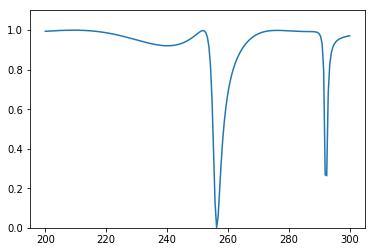

Test 31
True shape: [0.2963065  0.3        0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.2922576  0.29965678 0.20250142 0.12398127 0.13769057 0.11743309]]



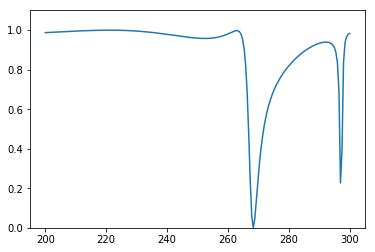

Test 32
True shape: [0.3        0.3        0.2        0.19507534 0.19507534 0.2       ]
Predicted shape: [[0.29697016 0.30039513 0.19800097 0.19925421 0.19544634 0.19816525]]



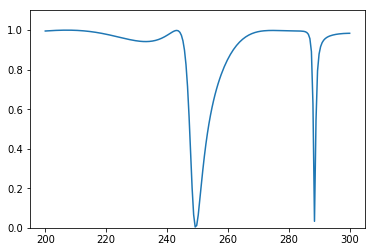

Test 33
True shape: [0.3        0.2        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.29927272 0.19807702 0.20012757 0.19801545 0.20407026 0.20001058]]



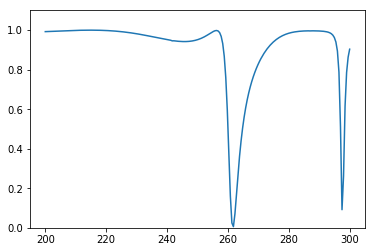

Test 34
True shape: [0.3       0.3       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.29038572 0.2976489  0.29323784 0.24475816 0.19375958 0.2953183 ]]



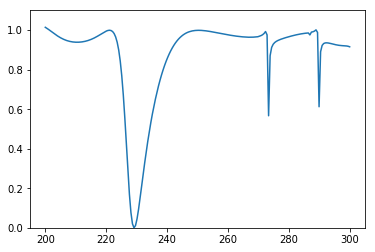

Test 35
True shape: [0.5        0.4        0.338636   0.3        0.2        0.19753767]
Predicted shape: [[0.49180084 0.4065496  0.34760022 0.3098155  0.21893604 0.21883479]]



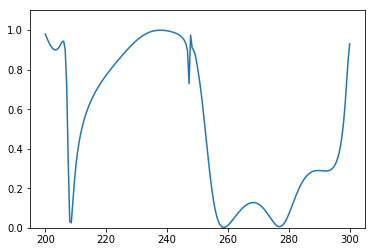

Test 36
True shape: [0.3        0.25051498 0.21968701 0.2        0.3        0.2       ]
Predicted shape: [[0.28904688 0.19885677 0.2335481  0.25374097 0.27054703 0.23519728]]



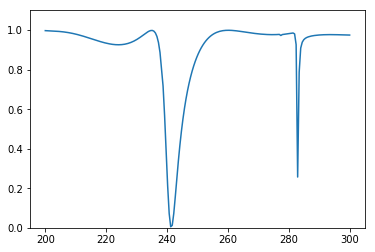

Test 37
True shape: [0.1        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.11018881 0.16538036 0.2055203  0.29683787 0.30222243 0.38469908]]



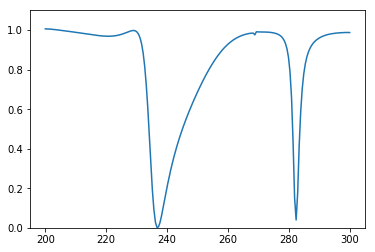

Test 38
True shape: [0.2       0.2       0.2370452 0.3       0.3       0.3      ]
Predicted shape: [[0.19919378 0.20684943 0.23745129 0.29796493 0.2959227  0.29564363]]



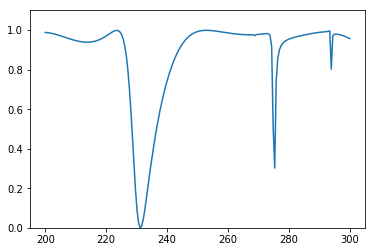

Test 39
True shape: [0.3        0.3        0.2370452  0.2        0.1        0.09876883]
Predicted shape: [[0.29760158 0.30242652 0.24041563 0.19839513 0.10293585 0.08821363]]



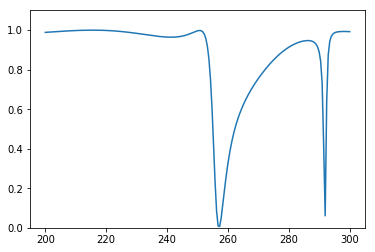

Test 40
True shape: [0.3        0.25051498 0.21968701 0.2        0.1        0.1       ]
Predicted shape: [[0.2992515  0.25200862 0.21712366 0.20172304 0.10202893 0.10610567]]



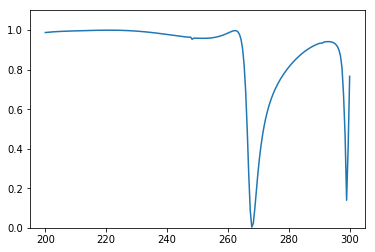

Test 41
True shape: [0.4        0.3        0.2        0.2        0.13169178 0.1       ]
Predicted shape: [[0.29001153 0.30240422 0.20928437 0.18949163 0.17135508 0.08910678]]



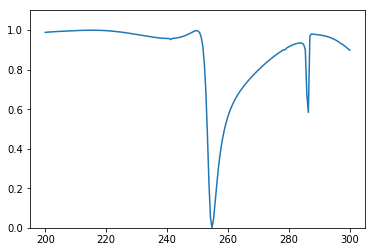

Test 42
True shape: [0.19753767 0.2        0.3        0.3        0.28887347 0.28531695]
Predicted shape: [[0.2521692  0.2503788  0.24319106 0.28968182 0.28324634 0.3049065 ]]



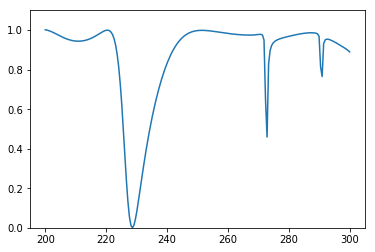

Test 43
True shape: [0.2 0.3 0.3 0.2 0.1 0.2]
Predicted shape: [[0.2977     0.2943173  0.23054996 0.2053748  0.15055004 0.13065875]]



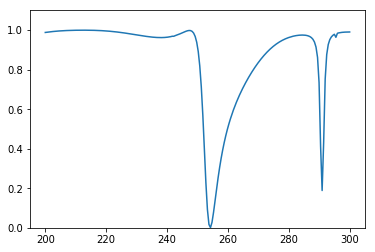

Test 44
True shape: [0.1        0.2        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.12191066 0.20156184 0.2188046  0.1970577  0.24662146 0.32106996]]



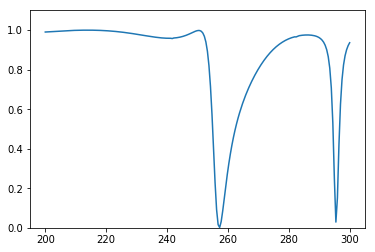

Test 45
True shape: [0.1        0.13169178 0.2        0.3        0.2370452  0.2       ]
Predicted shape: [[0.11653709 0.18500099 0.18166521 0.29154092 0.20664805 0.22376443]]



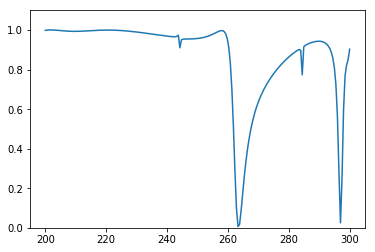

Test 46
True shape: [0.3        0.2370452  0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.2865479  0.20584008 0.19651857 0.24719578 0.20870511 0.12851751]]



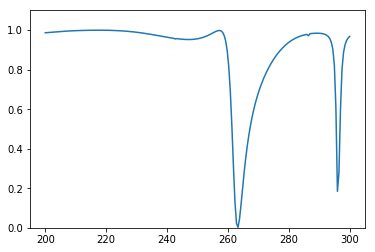

Test 47
True shape: [0.2 0.3 0.3 0.3 0.2 0.2]
Predicted shape: [[0.19519064 0.281145   0.3124862  0.2744996  0.22636478 0.23589619]]



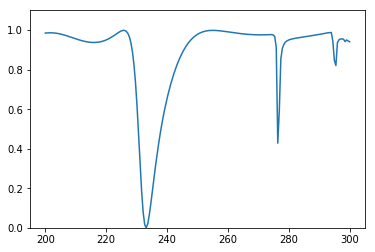

Test 48
True shape: [0.3       0.2       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.182636   0.3239872  0.2551418  0.19727814 0.2485044  0.23865938]]



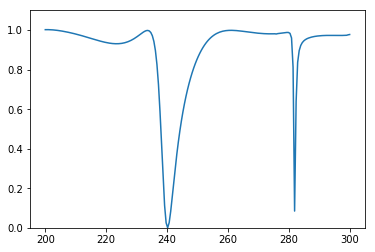

Test 49
True shape: [0.5       0.4389726 0.4       0.3       0.2963065 0.3      ]
Predicted shape: [[0.4974326  0.43930006 0.39860305 0.3001835  0.29112467 0.28961816]]



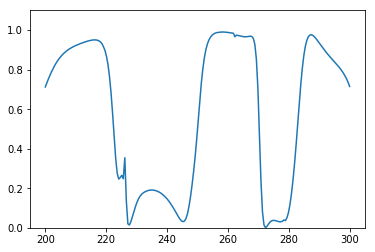

Test 50
True shape: [0.19753767 0.2        0.21968701 0.25051498 0.3        0.2       ]
Predicted shape: [[0.23656443 0.27840573 0.21905178 0.18035433 0.2764156  0.25349635]]



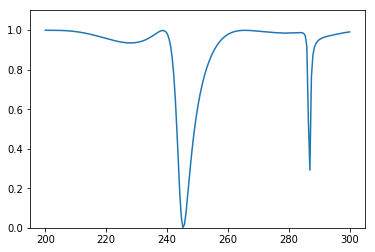

Test 51
True shape: [0.2 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.15805537 0.29058486 0.21633735 0.2167187  0.1913526  0.10997646]]



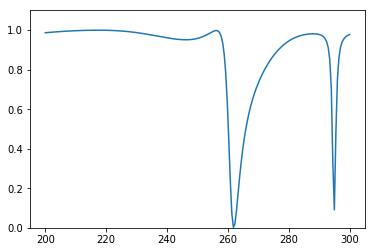

Test 52
True shape: [0.2        0.2        0.19753767 0.2        0.3        0.2963065 ]
Predicted shape: [[0.20173925 0.19320345 0.19632956 0.19908682 0.30486834 0.3026128 ]]



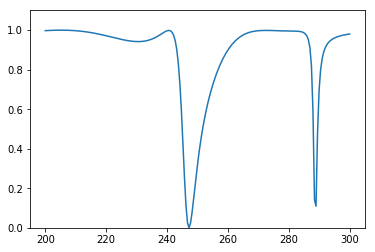

Test 53
True shape: [0.2       0.2       0.2       0.2       0.3       0.2963065]
Predicted shape: [[0.20208603 0.19518441 0.20040217 0.19810098 0.30299488 0.30178326]]



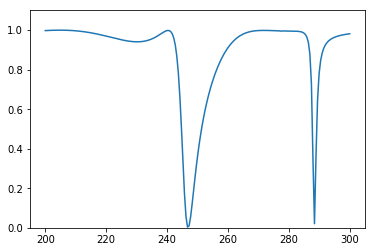

Test 54
True shape: [0.3        0.3        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.30965114 0.2708761  0.21466017 0.28852308 0.20786002 0.19612743]]



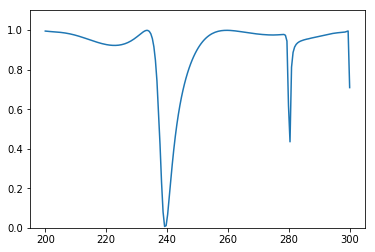

Test 55
True shape: [0.2       0.3       0.3       0.2963065 0.3       0.2      ]
Predicted shape: [[0.19267583 0.29476327 0.29342926 0.2980547  0.29602203 0.1966812 ]]



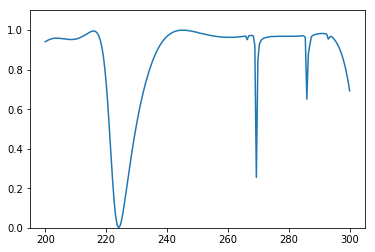

Test 56
True shape: [0.2963065  0.3        0.2        0.1        0.2        0.19753767]
Predicted shape: [[0.2858624  0.2988218  0.20187223 0.10278845 0.20862843 0.20315476]]



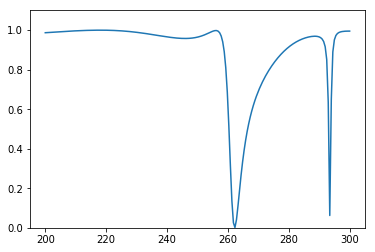

Test 57
True shape: [0.3        0.25051498 0.21968701 0.2        0.2        0.19753767]
Predicted shape: [[0.30043247 0.23384106 0.2429257  0.19970441 0.20200387 0.19465768]]



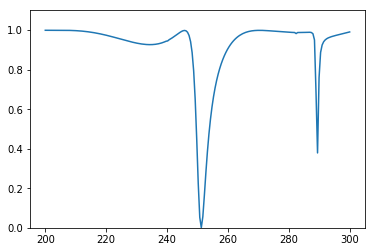

Test 58
True shape: [0.1        0.13169178 0.2        0.3        0.2963065  0.3       ]
Predicted shape: [[0.10468036 0.13537884 0.20365524 0.30236548 0.30201402 0.29719502]]



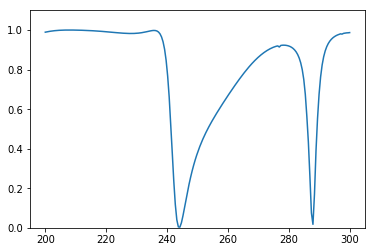

Test 59
True shape: [0.2       0.2       0.2370452 0.3       0.2370452 0.2      ]
Predicted shape: [[0.15597403 0.20413026 0.25191915 0.30697173 0.22581886 0.18982963]]



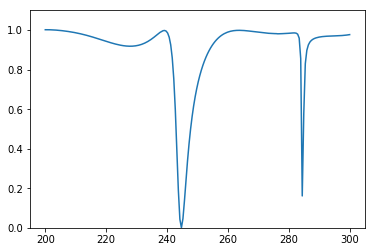

Test 60
True shape: [0.1       0.2       0.2370452 0.3       0.2       0.1      ]
Predicted shape: [[0.13986969 0.21330884 0.3076954  0.2450997  0.18190414 0.09493477]]



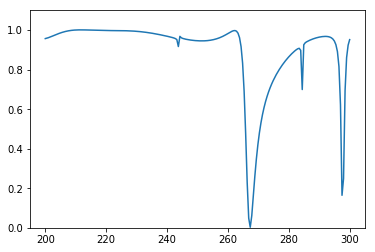

Test 61
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.19753767]
Predicted shape: [[0.20017621 0.21446747 0.27734774 0.26168677 0.22322704 0.20607649]]



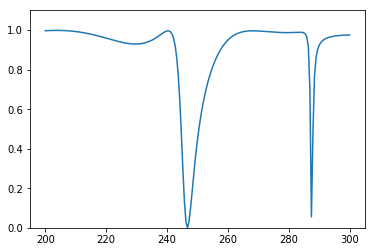

Test 62
True shape: [0.3        0.2        0.19507534 0.19507534 0.2        0.2       ]
Predicted shape: [[0.30091465 0.19975013 0.1962204  0.19784394 0.19977698 0.2014574 ]]



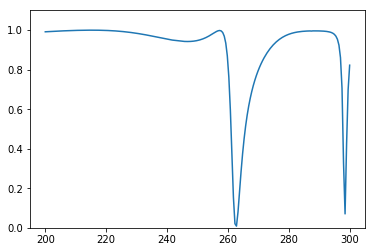

Test 63
True shape: [0.2        0.2        0.2370452  0.3        0.28887347 0.28531695]
Predicted shape: [[0.19996405 0.2821784  0.21374223 0.24233273 0.30476987 0.28688377]]



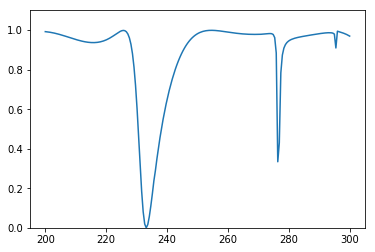

Test 64
True shape: [0.3       0.3       0.3       0.2       0.2370452 0.3      ]
Predicted shape: [[0.29860595 0.2979461  0.29957557 0.22941428 0.20934199 0.29229218]]



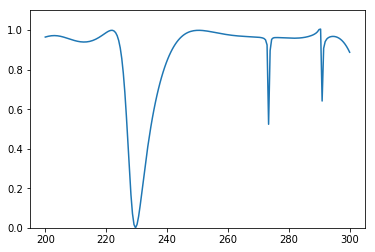

Test 65
True shape: [0.3       0.2       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.20936733 0.19992197 0.28903022 0.3167163  0.29328948 0.20247595]]



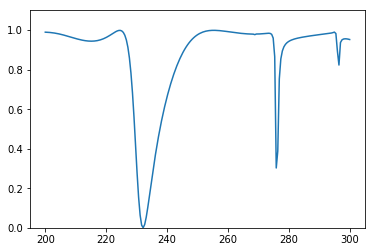

Test 66
True shape: [0.2 0.1 0.2 0.3 0.3 0.3]
Predicted shape: [[0.17778397 0.12098917 0.20852816 0.30373016 0.3033859  0.27949214]]



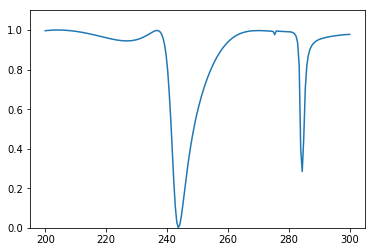

Test 67
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.2        0.3       ]
Predicted shape: [[0.27888614 0.28578043 0.30404633 0.22860432 0.24700594 0.22232395]]



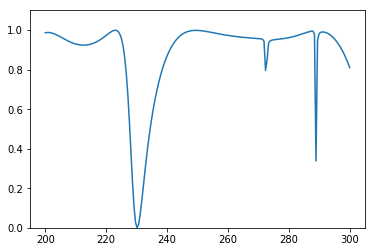

Test 68
True shape: [0.2       0.2       0.3       0.2963065 0.3       0.2963065]
Predicted shape: [[0.24639419 0.27959353 0.24429181 0.26699156 0.31783906 0.27308232]]



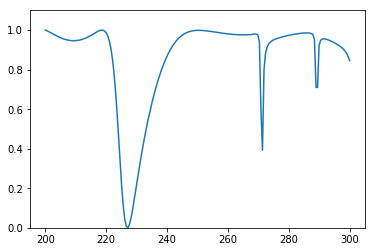

Test 69
True shape: [0.3      0.292613 0.292613 0.3      0.2      0.1     ]
Predicted shape: [[0.30774152 0.30580392 0.29079545 0.3108062  0.20904925 0.14275886]]



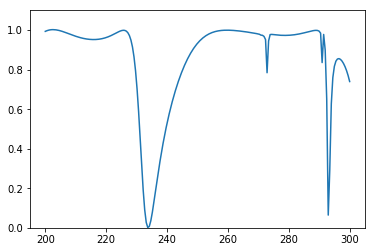

Test 70
True shape: [0.3        0.2        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.30526495 0.20150095 0.28987408 0.29601535 0.2030341  0.19697466]]



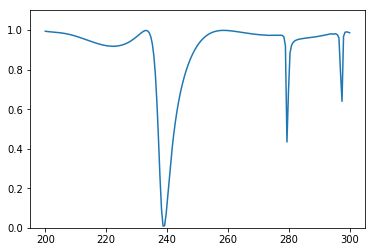

Test 71
True shape: [0.1902113  0.19258231 0.2        0.2370452  0.3        0.2963065 ]
Predicted shape: [[0.20893392 0.21995872 0.19380918 0.2307514  0.2922609  0.2958938 ]]



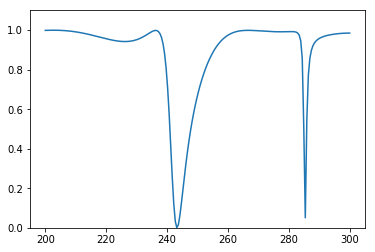

Test 72
True shape: [0.3 0.3 0.2 0.2 0.3 0.3]
Predicted shape: [[0.2835754  0.30625057 0.19411829 0.20632577 0.30049658 0.28160167]]



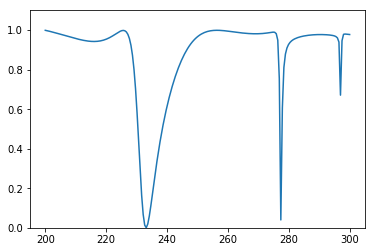

Test 73
True shape: [0.2 0.2 0.2 0.3 0.3 0.2]
Predicted shape: [[0.20159173 0.19916046 0.19316697 0.2971314  0.30591387 0.19443938]]



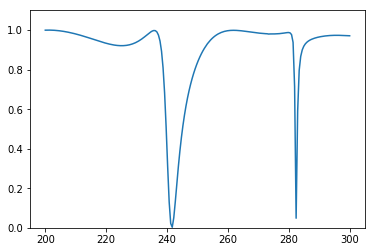

Test 74
True shape: [0.2       0.2       0.3       0.3       0.2963065 0.3      ]
Predicted shape: [[0.23906645 0.2778352  0.26247576 0.2414163  0.32313207 0.27667165]]



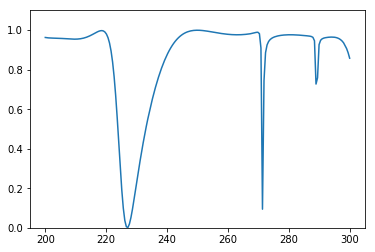

Test 75
True shape: [0.3        0.4        0.5        0.4        0.5        0.49384417]
Predicted shape: [[0.3045243  0.4043257  0.49795175 0.39946592 0.49887222 0.5009822 ]]



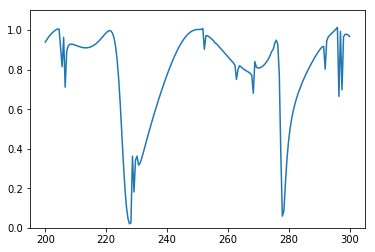

Test 76
True shape: [0.1 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.11272404 0.16377911 0.2018227  0.3066908  0.3024623  0.3973333 ]]



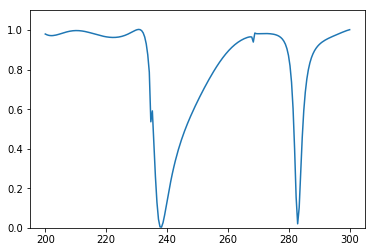

Test 77
True shape: [0.1       0.2       0.2370452 0.3       0.2963065 0.3      ]
Predicted shape: [[0.09956011 0.20532829 0.22264162 0.30052727 0.29788828 0.3113178 ]]



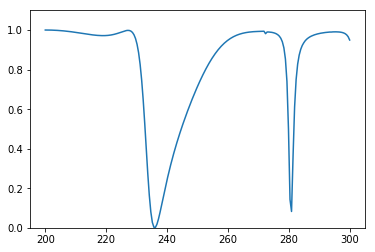

Test 78
True shape: [0.3        0.3        0.25606269 0.22825356 0.21057    0.2       ]
Predicted shape: [[0.27146003 0.28529778 0.29215166 0.2278364  0.20080723 0.2251178 ]]



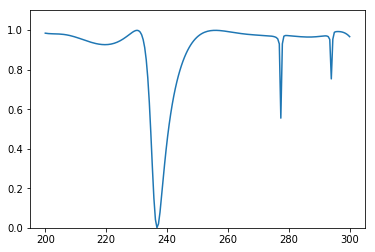

Test 79
True shape: [0.19753767 0.2        0.2370452  0.3        0.3        0.3       ]
Predicted shape: [[0.20086738 0.20131382 0.23390928 0.29890588 0.2995464  0.29633293]]



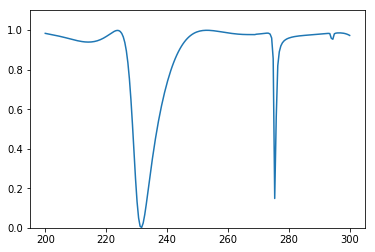

Test 80
True shape: [0.3        0.3        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.22155586 0.27892908 0.2875238  0.31117785 0.22066078 0.17375262]]



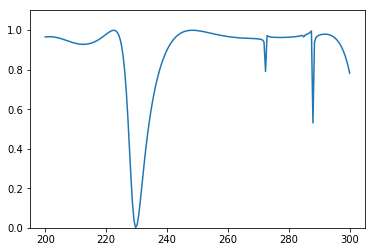

Test 81
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.1       ]
Predicted shape: [[0.19120607 0.18014231 0.19598088 0.2972657  0.2106072  0.10249497]]



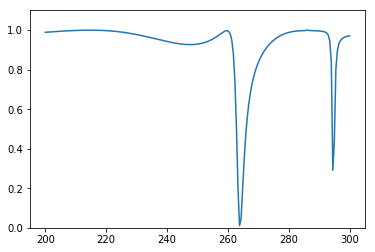

Test 82
True shape: [0.09876883 0.1        0.2        0.2370452  0.3        0.3       ]
Predicted shape: [[0.09258291 0.10241774 0.19772047 0.23341748 0.30442291 0.3087916 ]]



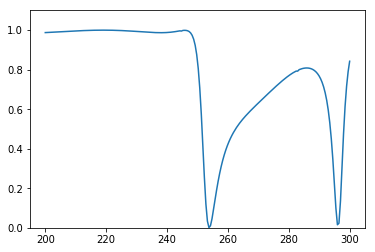

Test 83
True shape: [0.09876883 0.1        0.2        0.3        0.2963065  0.3       ]
Predicted shape: [[0.08647308 0.09936446 0.20015764 0.30049407 0.29843107 0.29207602]]



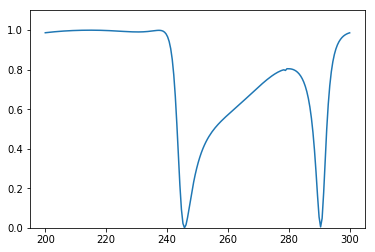

Test 84
True shape: [0.3        0.3        0.4        0.5        0.4        0.39507534]
Predicted shape: [[0.29861116 0.3161145  0.38531262 0.4825519  0.3980902  0.39054295]]



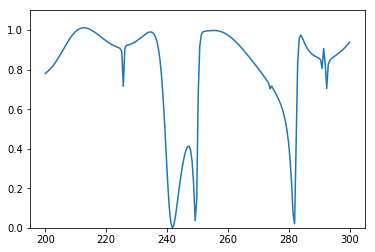

Test 85
True shape: [0.3       0.2370452 0.2       0.2       0.3       0.4      ]
Predicted shape: [[0.1911006  0.2862027  0.2824342  0.23238361 0.2569321  0.26734993]]



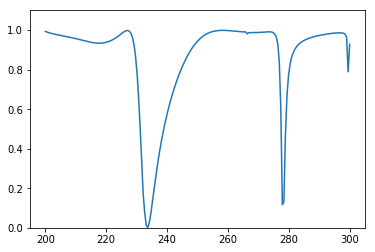

Test 86
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.1       ]
Predicted shape: [[0.2015687  0.21894431 0.2385023  0.22835147 0.21797346 0.17374003]]



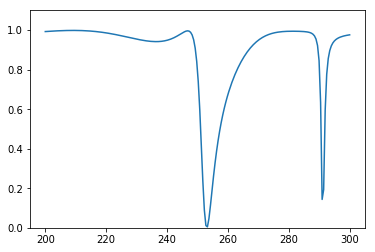

Test 87
True shape: [0.2        0.2370452  0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.19194451 0.23613167 0.2974847  0.20203504 0.20079996 0.21162106]]



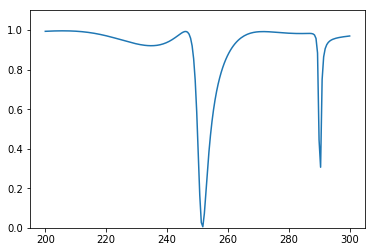

Test 88
True shape: [0.3 0.2 0.2 0.2 0.3 0.4]
Predicted shape: [[0.1804865  0.1755451  0.20066094 0.24101454 0.31129128 0.41321328]]



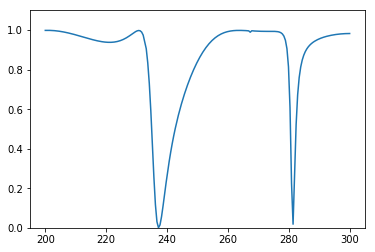

Test 89
True shape: [0.2       0.2       0.3       0.2963065 0.3       0.2      ]
Predicted shape: [[0.20122358 0.20455313 0.30854672 0.30385125 0.29663807 0.19608307]]



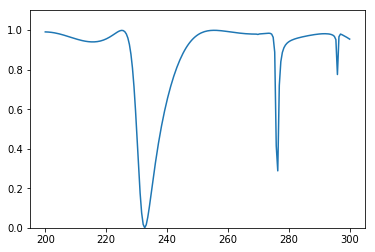

Test 90
True shape: [0.3       0.2       0.2       0.2       0.2370452 0.3      ]
Predicted shape: [[0.2932194  0.20296085 0.19543344 0.20114845 0.23838459 0.30055425]]



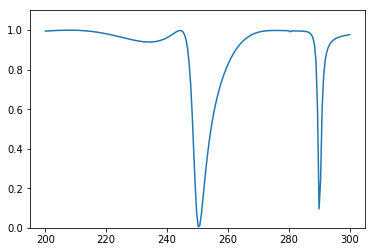

Test 91
True shape: [0.2        0.2        0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.18968847 0.2026478  0.2904191  0.21323338 0.19959311 0.17461152]]



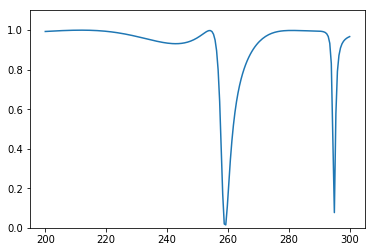

Test 92
True shape: [0.2 0.2 0.1 0.2 0.3 0.3]
Predicted shape: [[0.19290137 0.18642816 0.10402775 0.1959039  0.3086826  0.31039906]]



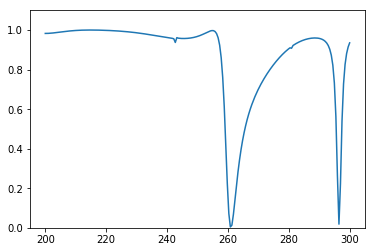

Test 93
True shape: [0.3 0.2 0.2 0.3 0.2 0.1]
Predicted shape: [[0.25993222 0.2694187  0.19949618 0.23113772 0.20223282 0.15618087]]



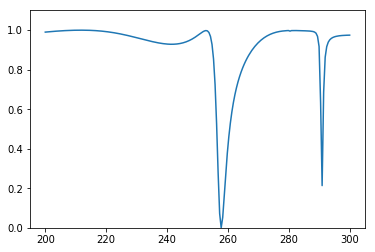

Test 94
True shape: [0.2        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.26172698 0.21626917 0.22799963 0.26482671 0.20777549 0.1995212 ]]



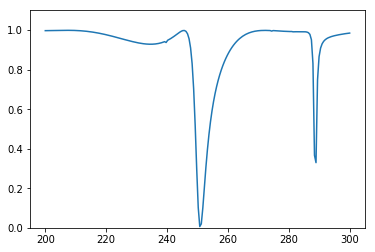

Test 95
True shape: [0.3       0.2370452 0.2       0.3       0.2       0.1      ]
Predicted shape: [[0.19479638 0.26200444 0.19707328 0.28688335 0.212311   0.11992396]]



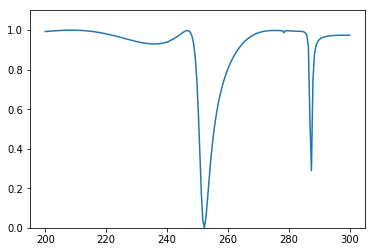

Test 96
True shape: [0.3        0.2        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.27636504 0.19755584 0.19276452 0.3092179  0.20067103 0.1920985 ]]



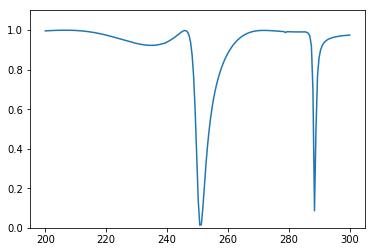

Test 97
True shape: [0.3        0.2        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.18297756 0.20990217 0.30835897 0.19885367 0.23309238 0.27988073]]



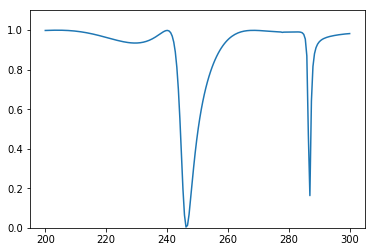

Test 98
True shape: [0.2        0.13169178 0.1        0.2        0.3        0.4       ]
Predicted shape: [[0.190635   0.11981708 0.1326657  0.2116405  0.30575773 0.399715  ]]



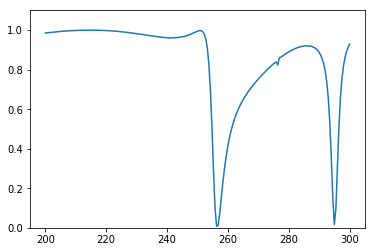

Test 99
True shape: [0.3       0.2       0.2       0.2370452 0.3       0.2963065]
Predicted shape: [[0.28893918 0.20776376 0.19865078 0.2409521  0.30606246 0.29333302]]



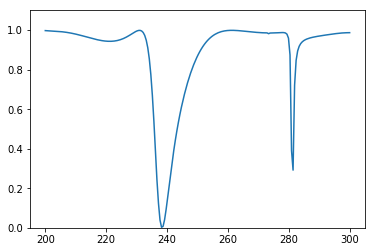

Test 100
True shape: [0.3       0.2370452 0.2       0.3       0.3       0.2      ]
Predicted shape: [[0.25928694 0.25691688 0.21554312 0.24985594 0.2956669  0.2739306 ]]



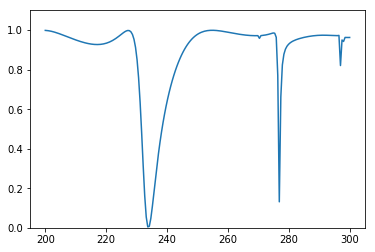

Test 101
True shape: [0.19753767 0.2        0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.1874676  0.1912669  0.19899589 0.20676956 0.30229953 0.19528595]]



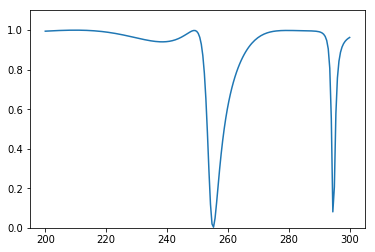

Test 102
True shape: [0.09876883 0.1        0.2        0.2370452  0.3        0.2963065 ]
Predicted shape: [[0.09362459 0.10071015 0.1976169  0.22959304 0.302444   0.31393278]]



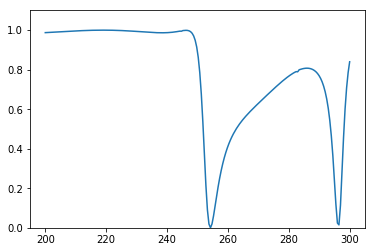

Test 103
True shape: [0.2        0.2        0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.19044346 0.20874104 0.30267763 0.2928179  0.2588562  0.23790427]]



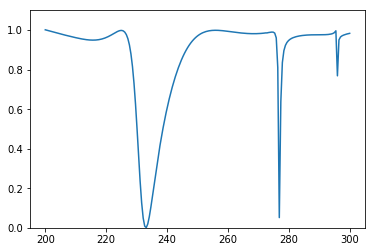

Test 104
True shape: [0.2963065 0.3       0.3       0.2       0.3       0.2      ]
Predicted shape: [[0.29176956 0.30203536 0.28812325 0.20538303 0.28956398 0.2223328 ]]



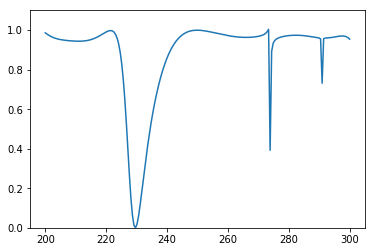

Test 105
True shape: [0.1       0.2       0.2370452 0.3       0.3       0.2963065]
Predicted shape: [[0.0994947  0.20612091 0.23305187 0.30059928 0.29931992 0.2978386 ]]



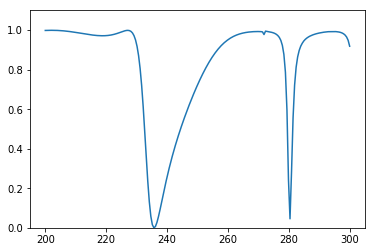

Test 106
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.3       ]
Predicted shape: [[0.19170764 0.16919109 0.20428967 0.2687648  0.29375455 0.38351122]]



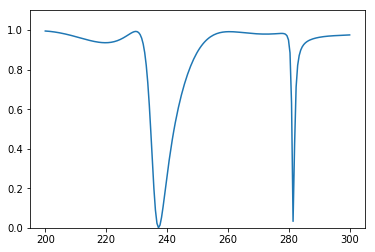

Test 107
True shape: [0.2963065 0.3       0.3       0.2       0.2       0.1      ]
Predicted shape: [[0.3020512  0.30043614 0.29857022 0.19791767 0.20453618 0.10374865]]



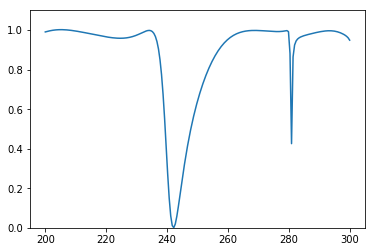

Test 108
True shape: [0.2        0.21057    0.22825356 0.25606269 0.3        0.4       ]
Predicted shape: [[0.19261035 0.19713673 0.2193169  0.29623407 0.30299482 0.39128736]]



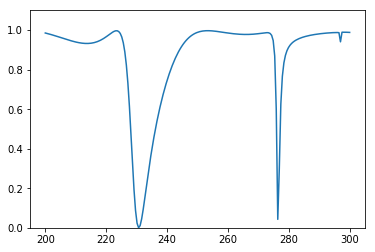

Test 109
True shape: [0.2        0.1        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.20115861 0.10800347 0.21446994 0.26123038 0.27257338 0.18170527]]



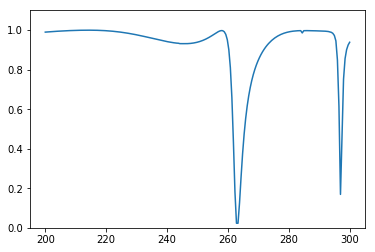

Test 110
True shape: [0.5       0.4389726 0.4       0.3       0.3       0.3      ]
Predicted shape: [[0.4909581  0.4355282  0.39119774 0.3061158  0.28391403 0.2801365 ]]



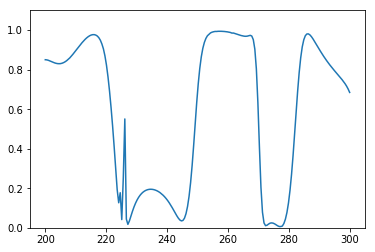

Test 111
True shape: [0.3 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.24250266 0.24557707 0.25717503 0.20249945 0.31748047 0.39545488]]



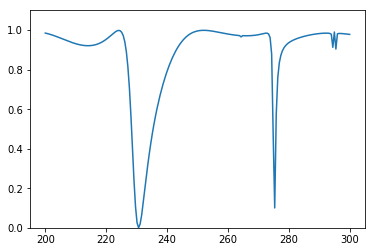

Test 112
True shape: [0.2        0.19753767 0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.1930153  0.19823858 0.19780815 0.20491812 0.2999985  0.19998483]]



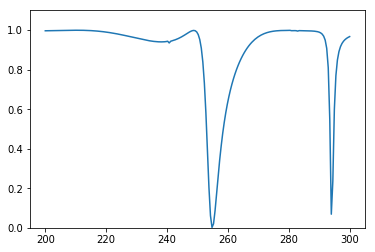

Test 113
True shape: [0.2        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.2015686  0.29598296 0.19581255 0.19844747 0.19891135 0.21586877]]



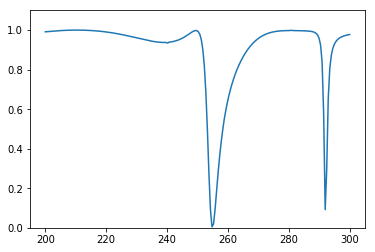

Test 114
True shape: [0.2       0.2370452 0.3       0.2       0.3       0.2963065]
Predicted shape: [[0.19755173 0.2227659  0.29058054 0.23116744 0.29859614 0.29172406]]



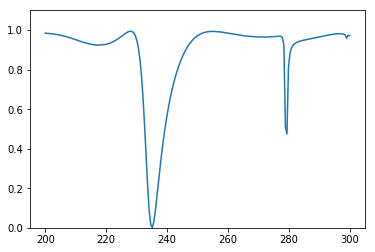

Test 115
True shape: [0.19753767 0.2        0.3        0.2963065  0.3        0.2       ]
Predicted shape: [[0.1792402  0.24150017 0.27324188 0.26835102 0.2917768  0.24084024]]



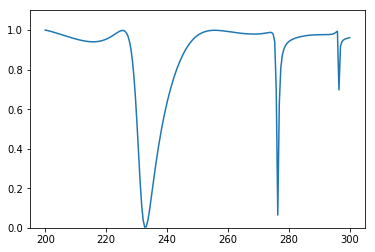

Test 116
True shape: [0.3 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.2836343  0.28222728 0.22833648 0.19768506 0.17145978 0.10052347]]



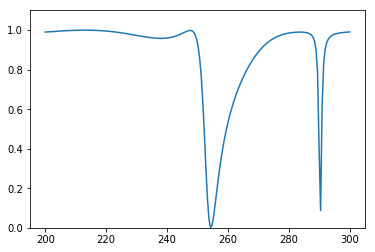

Test 117
True shape: [0.2963065  0.3        0.2        0.13169178 0.1        0.1       ]
Predicted shape: [[0.2986827  0.2993976  0.19776407 0.14264998 0.09833366 0.09731872]]



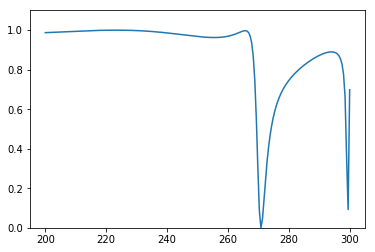

Test 118
True shape: [0.3        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.30229396 0.3000614  0.19596443 0.20195878 0.19836879 0.20094934]]



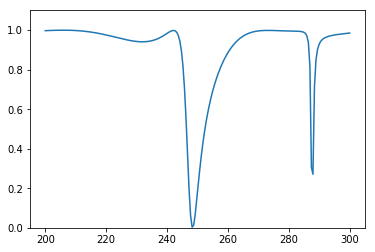

Test 119
True shape: [0.2       0.3       0.2370452 0.2       0.2       0.1      ]
Predicted shape: [[0.30586255 0.30641443 0.19394305 0.17731422 0.1932004  0.14509508]]



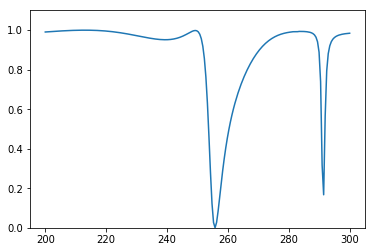

Test 120
True shape: [0.4        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.39514655 0.29580083 0.2425951  0.20145255 0.20081425 0.1913192 ]]



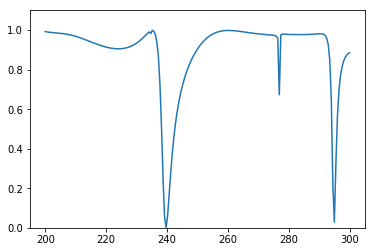

Test 121
True shape: [0.2        0.3        0.25606269 0.22825356 0.21057    0.2       ]
Predicted shape: [[0.1663577  0.21011081 0.2768029  0.3226505  0.2746971  0.23243995]]



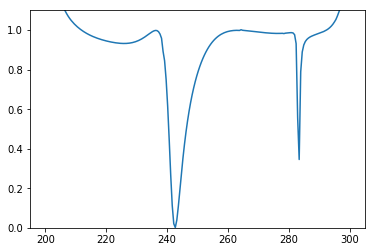

Test 122
True shape: [0.2963065 0.3       0.2       0.2       0.3       0.2      ]
Predicted shape: [[0.29220742 0.30450666 0.2002286  0.20180586 0.30433968 0.20510364]]



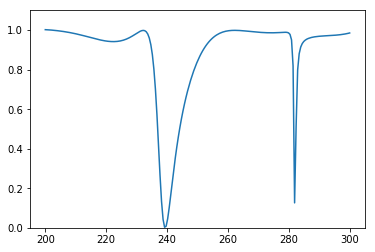

Test 123
True shape: [0.1       0.1       0.2       0.2370452 0.3       0.4      ]
Predicted shape: [[0.0949038  0.11721084 0.19884953 0.2663057  0.2950775  0.363037  ]]



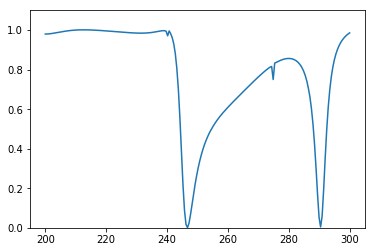

Test 124
True shape: [0.3       0.2370452 0.2       0.3       0.3       0.2963065]
Predicted shape: [[0.3088441  0.26607412 0.2017977  0.29918623 0.2987076  0.2784671 ]]



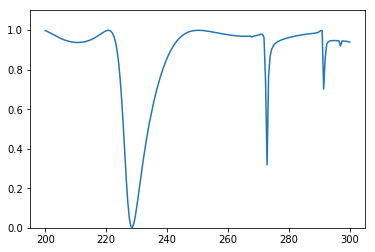

Test 125
True shape: [0.1 0.1 0.2 0.3 0.3 0.4]
Predicted shape: [[0.11024299 0.12559864 0.19863534 0.30271596 0.30434197 0.4113626 ]]



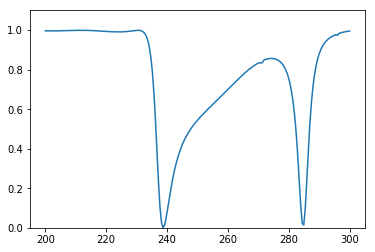

Test 126
True shape: [0.3        0.2        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.29847482 0.19748965 0.20227212 0.1977635  0.2063159  0.19969158]]



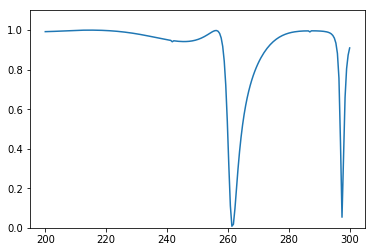

Test 127
True shape: [0.3        0.25051498 0.21968701 0.2        0.2        0.1       ]
Predicted shape: [[0.182859   0.19840488 0.30564928 0.23148581 0.20527172 0.09141523]]



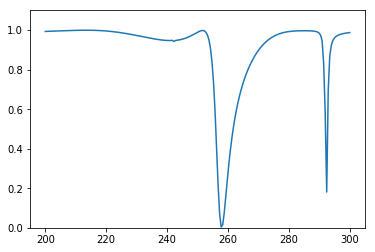

Test 128
True shape: [0.2 0.3 0.3 0.2 0.1 0.1]
Predicted shape: [[0.19899425 0.3018151  0.2978199  0.19869718 0.10383325 0.10386095]]



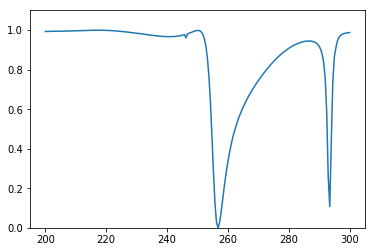

Test 129
True shape: [0.2 0.3 0.3 0.2 0.2 0.2]
Predicted shape: [[0.20122883 0.29808533 0.2964769  0.18614998 0.20700869 0.21617123]]



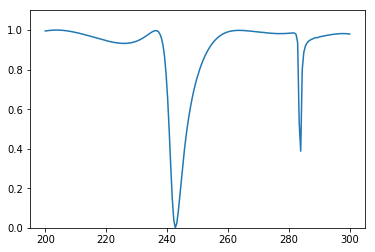

Test 130
True shape: [0.2        0.3        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.19835249 0.28361762 0.31339964 0.27040452 0.22308606 0.23870817]]



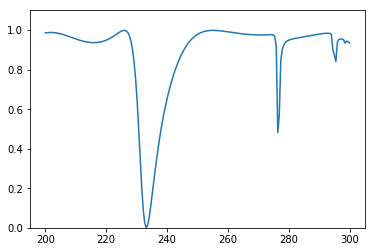

Test 131
True shape: [0.2427051  0.24573045 0.25519524 0.2723943  0.3        0.2       ]
Predicted shape: [[0.17388886 0.25407538 0.2664438  0.2645812  0.27422577 0.26613805]]



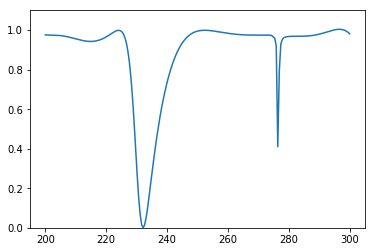

Test 132
True shape: [0.2 0.3 0.2 0.2 0.1 0.2]
Predicted shape: [[0.2778358  0.300158   0.20577303 0.12823057 0.15412356 0.14373417]]



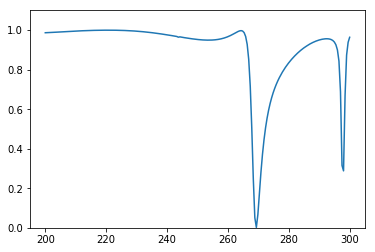

Test 133
True shape: [0.19753767 0.2        0.3        0.2        0.2370452  0.3       ]
Predicted shape: [[0.23107141 0.2077584  0.2573629  0.20386863 0.29280072 0.2297577 ]]



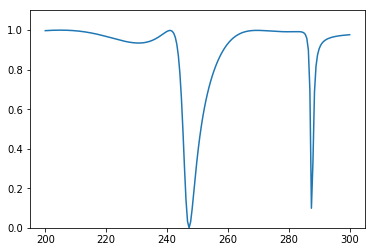

Test 134
True shape: [0.2 0.3 0.3 0.2 0.3 0.3]
Predicted shape: [[0.20699543 0.3015456  0.29730994 0.19662964 0.29574615 0.30477768]]



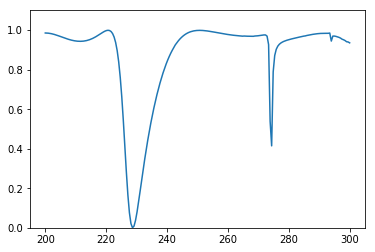

Test 135
True shape: [0.2963065  0.3        0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.2975969  0.30149612 0.19538999 0.20785555 0.10484643 0.10505833]]



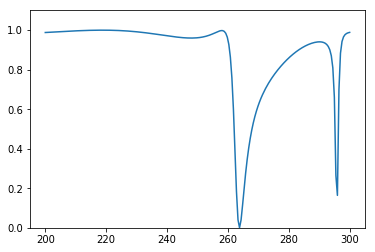

Test 136
True shape: [0.2 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.20867628 0.26399308 0.26542908 0.28328404 0.22752894 0.2839386 ]]



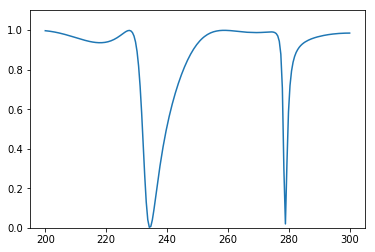

Test 137
True shape: [0.19753767 0.2        0.3        0.2        0.3        0.4       ]
Predicted shape: [[0.20995384 0.25667024 0.25656828 0.2869746  0.24003789 0.285991  ]]



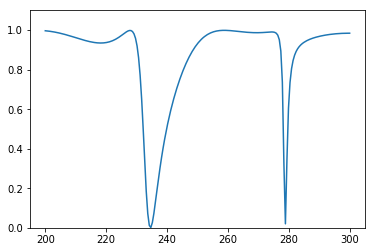

Test 138
True shape: [0.19753767 0.2        0.2        0.3        0.2        0.3       ]
Predicted shape: [[0.2051844  0.19682044 0.19052991 0.30724585 0.1989879  0.28366646]]



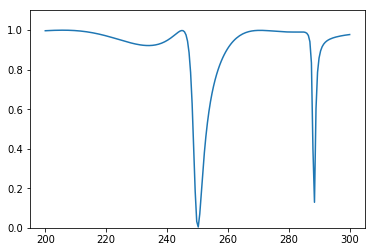

Test 139
True shape: [0.2        0.3        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.29878047 0.30462724 0.19773242 0.10187808 0.20201544 0.30079624]]



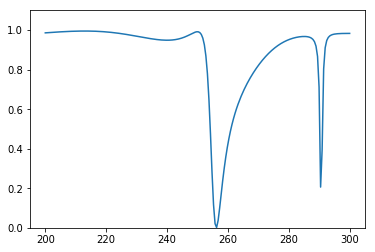

Test 140
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.2       ]
Predicted shape: [[0.18850625 0.19453791 0.19873157 0.30120853 0.19922431 0.2078671 ]]



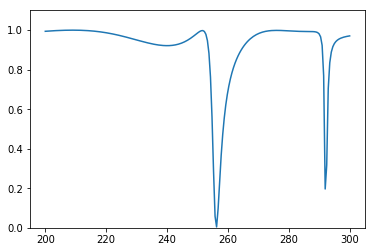

Test 141
True shape: [0.3       0.3       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.2406874  0.30744898 0.24069563 0.2969275  0.30052465 0.23228051]]



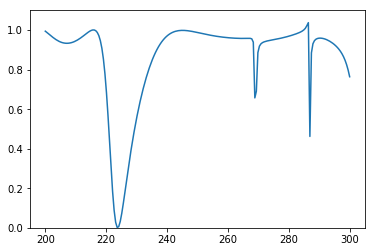

Test 142
True shape: [0.1 0.2 0.3 0.3 0.2 0.3]
Predicted shape: [[0.08577386 0.18949363 0.25373426 0.28454998 0.2680574  0.2459284 ]]



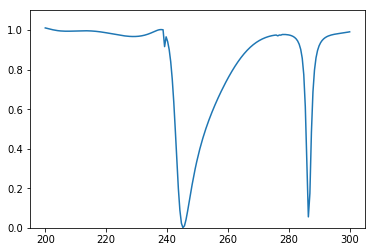

Test 143
True shape: [0.2       0.2370452 0.3       0.3       0.3       0.2      ]
Predicted shape: [[0.20265189 0.22617033 0.27879274 0.30052906 0.3051664  0.23562182]]



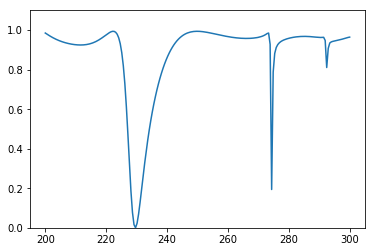

Test 144
True shape: [0.2 0.2 0.3 0.3 0.2 0.1]
Predicted shape: [[0.18155956 0.21341795 0.28896287 0.2790938  0.2100687  0.12142465]]



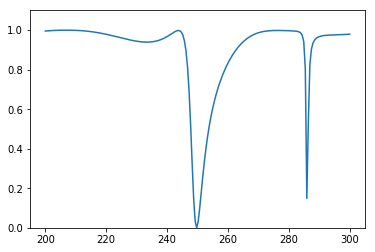

Test 145
True shape: [0.3        0.2370452  0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.29919457 0.23315874 0.19955915 0.19671619 0.20220892 0.20051143]]



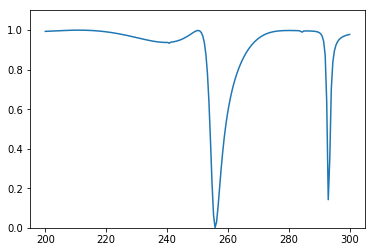

Test 146
True shape: [0.3       0.2370452 0.2       0.3       0.2       0.2      ]
Predicted shape: [[0.2938413  0.21799496 0.19911337 0.29704183 0.2157087  0.20283711]]



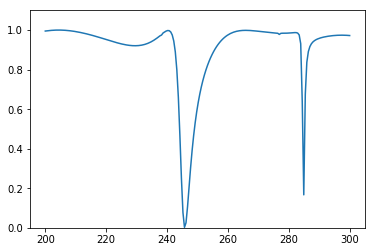

Test 147
True shape: [0.1902113  0.19258231 0.2        0.3        0.2        0.3       ]
Predicted shape: [[0.17460576 0.21286285 0.20343673 0.21218807 0.26254895 0.30404466]]



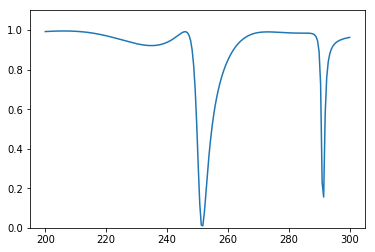

Test 148
True shape: [0.2       0.2       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.1972785  0.20172733 0.19916752 0.29934126 0.30013183 0.29879692]]



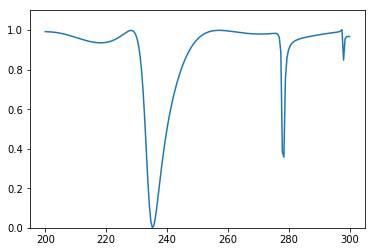

Test 149
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.3       ]
Predicted shape: [[0.18742162 0.23862138 0.2974542  0.21959165 0.22414707 0.27229366]]



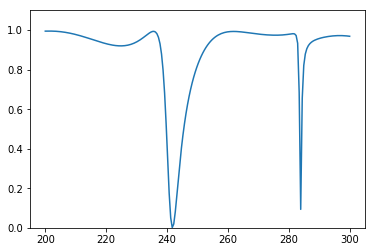

Test 150
True shape: [0.2        0.2370452  0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.21041363 0.2399984  0.28423738 0.190799   0.19254336 0.21513364]]



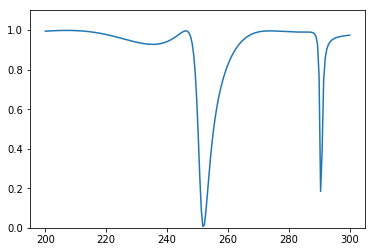

Test 151
True shape: [0.2963065  0.3        0.25051498 0.21968701 0.2        0.1       ]
Predicted shape: [[0.29553682 0.30298167 0.25238463 0.22370556 0.21347627 0.09904551]]



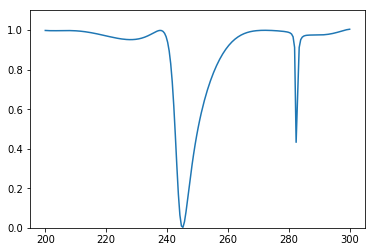

Test 152
True shape: [0.3 0.2 0.3 0.2 0.2 0.1]
Predicted shape: [[0.17894387 0.19399035 0.3171029  0.23611644 0.20270911 0.085475  ]]



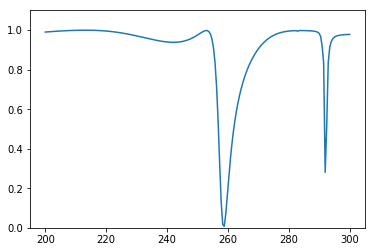

Test 153
True shape: [0.2963065 0.3       0.2       0.2       0.2       0.1      ]
Predicted shape: [[0.29472417 0.29201335 0.20075029 0.199465   0.19943798 0.10318372]]



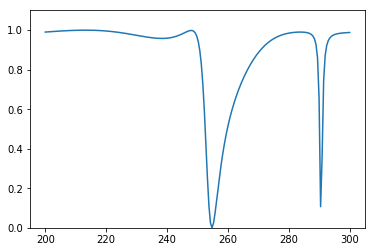

Test 154
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.1      ]
Predicted shape: [[0.22918493 0.21437192 0.2440756  0.29029292 0.21220224 0.14621669]]



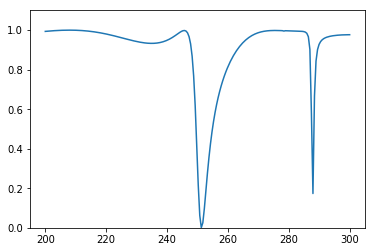

Test 155
True shape: [0.2        0.2        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.29432076 0.2234514  0.2359173  0.21284786 0.21527117 0.2801593 ]]



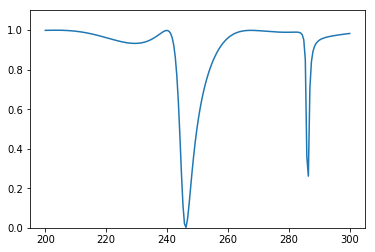

Test 156
True shape: [0.3        0.25051498 0.21968701 0.2        0.19753767 0.2       ]
Predicted shape: [[0.30384883 0.22049072 0.26827615 0.19807047 0.20126323 0.19419147]]



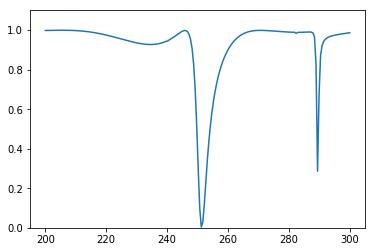

Test 157
True shape: [0.1       0.2       0.3       0.2       0.2370452 0.3      ]
Predicted shape: [[0.09864315 0.20153192 0.29565927 0.22151405 0.21615228 0.29993445]]



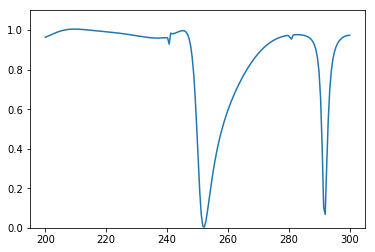

Test 158
True shape: [0.1       0.1       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.0993776  0.10759792 0.195759   0.30168688 0.29603237 0.28986788]]



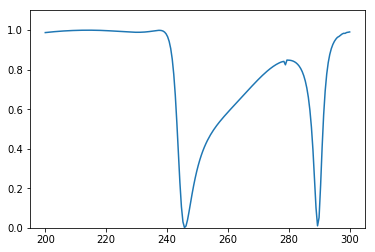

Test 159
True shape: [0.19753767 0.2        0.19753767 0.2        0.2        0.3       ]
Predicted shape: [[0.19308639 0.1990141  0.20123205 0.19661859 0.20009273 0.30431855]]



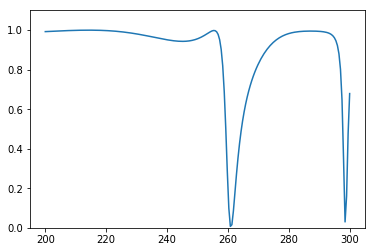

Test 160
True shape: [0.2       0.2       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.19655329 0.17634693 0.26542026 0.25386354 0.23440297 0.3148247 ]]



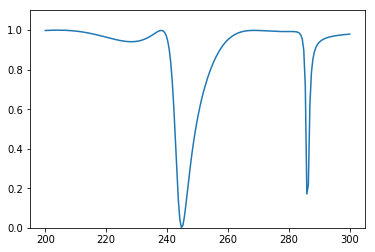

Test 161
True shape: [0.3        0.2370452  0.2        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.25726086 0.20769173 0.22447559 0.1927846  0.22261047 0.20667928]]



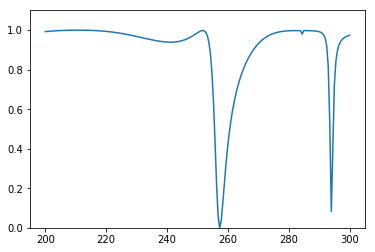

Test 162
True shape: [0.19753767 0.2        0.3        0.2        0.2        0.2       ]
Predicted shape: [[0.19320792 0.2033341  0.29720733 0.2050941  0.19963773 0.19531316]]



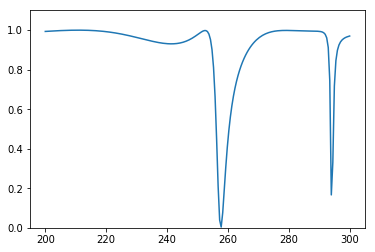

Test 163
True shape: [0.2       0.2       0.3       0.3       0.2370452 0.2      ]
Predicted shape: [[0.19579747 0.2107721  0.29943693 0.30238563 0.22940157 0.20273347]]



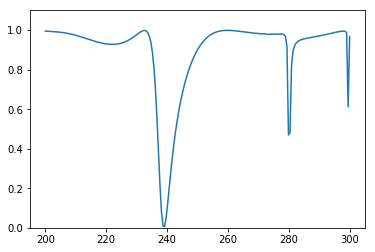

Test 164
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.2       ]
Predicted shape: [[0.18468696 0.1964516  0.24935877 0.31850013 0.21511634 0.26444453]]



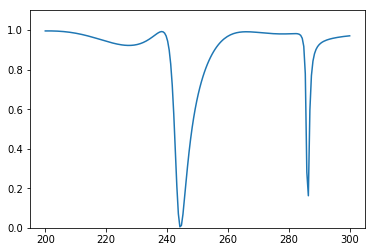

Test 165
True shape: [0.3       0.3       0.2963065 0.3       0.3       0.4      ]
Predicted shape: [[0.28494757 0.29821974 0.30080074 0.29397988 0.30180183 0.3852658 ]]



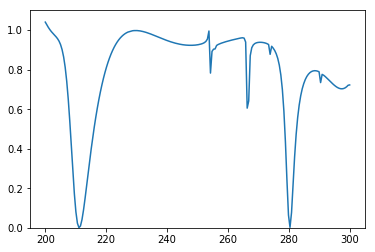

Test 166
True shape: [0.09876883 0.1        0.2        0.3        0.4        0.3       ]
Predicted shape: [[0.10205138 0.09824595 0.19450915 0.29535174 0.34953308 0.40030622]]



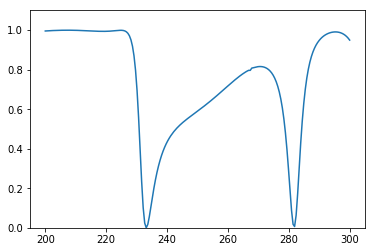

Test 167
True shape: [0.2        0.2        0.21057    0.22825356 0.25606269 0.3       ]
Predicted shape: [[0.23178762 0.2534671  0.20548895 0.20627832 0.25767773 0.21254218]]



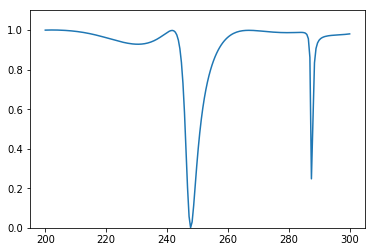

In [15]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))

In [16]:
model.save('two_peak_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('two_peak_model.h5')

Test 0
True shape: [0.2        0.3        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.27506706 0.3008455  0.2077947  0.21394753 0.26430213 0.29342115]]



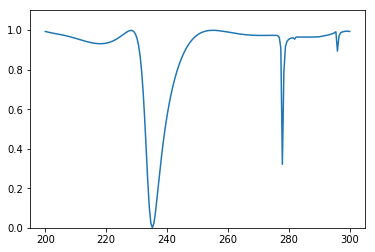

Test 1
True shape: [0.1       0.2       0.2       0.3       0.3       0.2963065]
Predicted shape: [[0.10141459 0.20454657 0.20159754 0.30052036 0.29552215 0.2977123 ]]



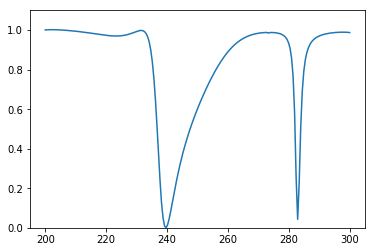

Test 2
True shape: [0.2       0.3       0.2370452 0.2       0.3       0.2963065]
Predicted shape: [[0.2504233  0.20428908 0.26477242 0.24439234 0.3152173  0.24343295]]



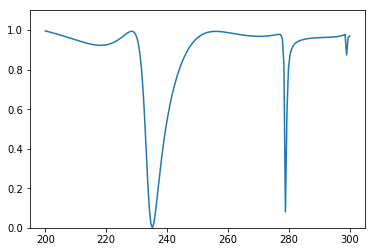

Test 3
True shape: [0.1       0.2       0.2       0.2370452 0.3       0.3      ]
Predicted shape: [[0.1005176  0.20757574 0.20482922 0.23936418 0.30443627 0.29565915]]



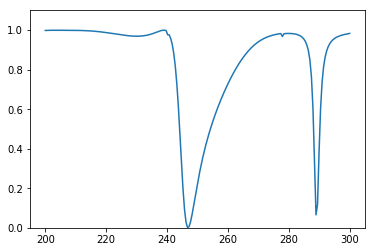

Test 4
True shape: [0.19753767 0.2        0.2370452  0.3        0.28887347 0.28531695]
Predicted shape: [[0.22410426 0.24985251 0.21760774 0.23487708 0.3075231  0.30578277]]



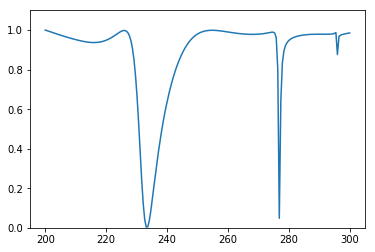

Test 5
True shape: [0.2        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.19770998 0.2004458  0.21724397 0.24869412 0.29693446 0.39733523]]



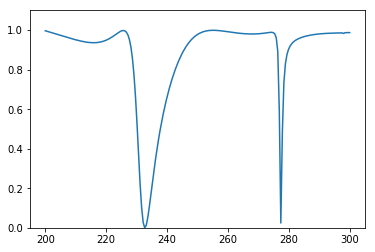

Test 6
True shape: [0.2        0.3        0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.19410187 0.2959304  0.19794554 0.19990295 0.19832389 0.2015259 ]]



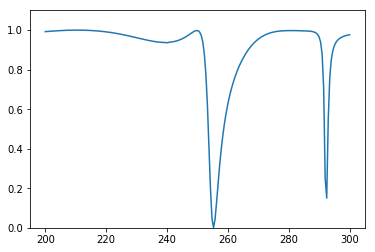

Test 7
True shape: [0.3 0.3 0.2 0.3 0.2 0.2]
Predicted shape: [[0.29541534 0.27043158 0.21659118 0.28717774 0.20891218 0.20095946]]



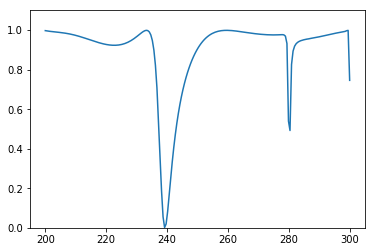

Test 8
True shape: [0.3        0.2370452  0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.20043787 0.1249885  0.20134068 0.23217478 0.29540062 0.20020871]]



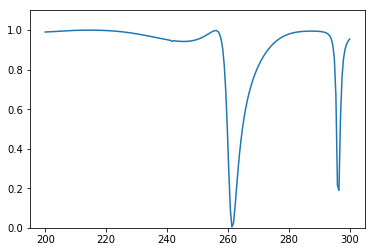

Test 9
True shape: [0.3        0.3        0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.28666046 0.29079634 0.2079384  0.1127845  0.12635851 0.18798569]]



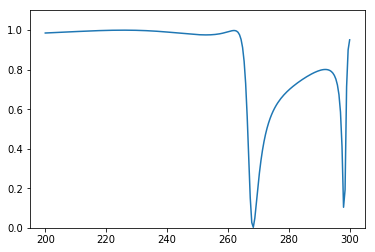

Test 10
True shape: [0.4        0.3        0.25051498 0.21968701 0.2        0.19753767]
Predicted shape: [[0.37244368 0.29786184 0.26989746 0.21956861 0.20636353 0.19356628]]



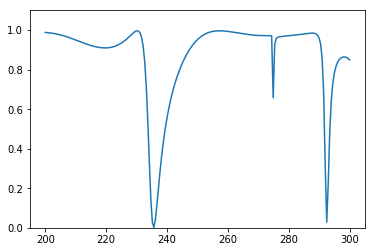

Test 11
True shape: [0.2 0.3 0.2 0.2 0.3 0.3]
Predicted shape: [[0.20075071 0.2909655  0.19295043 0.20706484 0.30858457 0.30089396]]



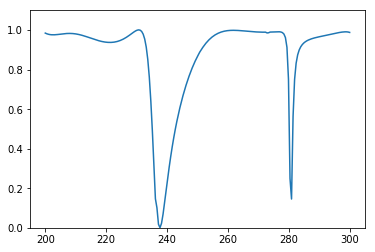

Test 12
True shape: [0.3        0.292613   0.292613   0.3        0.28887347 0.28531695]
Predicted shape: [[0.28745168 0.29305366 0.2930042  0.2970252  0.2965526  0.29336572]]



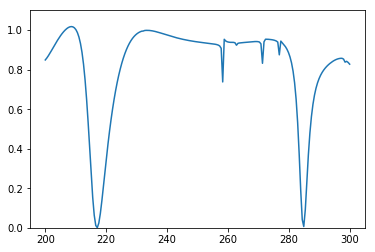

Test 13
True shape: [0.3        0.2        0.19753767 0.2        0.3        0.4       ]
Predicted shape: [[0.16209617 0.16174889 0.20346746 0.27402872 0.31165528 0.40354106]]



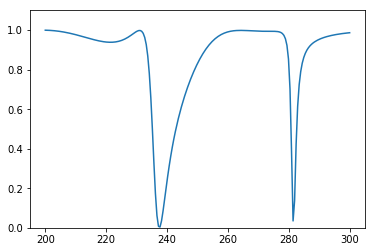

Test 14
True shape: [0.4        0.3        0.2370452  0.2        0.19753767 0.2       ]
Predicted shape: [[0.40359756 0.30394745 0.24129787 0.18757874 0.20434856 0.20660627]]



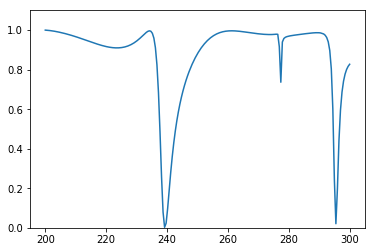

Test 15
True shape: [0.1        0.2        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.1067754  0.20763323 0.2954331  0.29153216 0.2009638  0.20006193]]



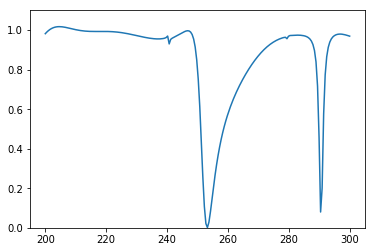

Test 16
True shape: [0.2        0.19753767 0.2        0.2        0.3        0.4       ]
Predicted shape: [[0.19781658 0.20464563 0.20034385 0.19961545 0.3021749  0.40237424]]



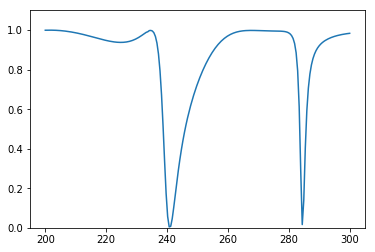

Test 17
True shape: [0.2       0.2370452 0.3       0.3       0.2       0.3      ]
Predicted shape: [[0.2990594  0.25954753 0.22483677 0.20334503 0.29351592 0.29153916]]



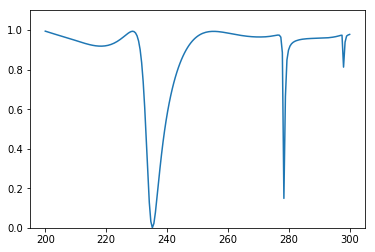

Test 18
True shape: [0.2        0.19753767 0.2        0.3        0.2370452  0.2       ]
Predicted shape: [[0.18681172 0.18979439 0.19845983 0.29973477 0.23502046 0.2006607 ]]



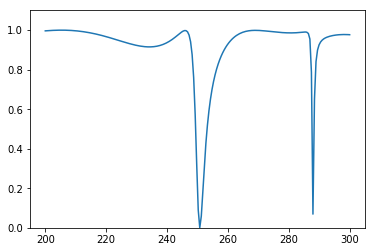

Test 19
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.3      ]
Predicted shape: [[0.19767356 0.3197327  0.22493193 0.21329382 0.2428746  0.28226775]]



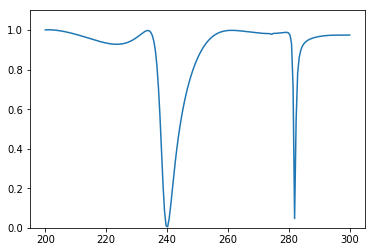

Test 20
True shape: [0.3        0.3        0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.27093646 0.25603846 0.18538228 0.20992959 0.20274724 0.16978064]]



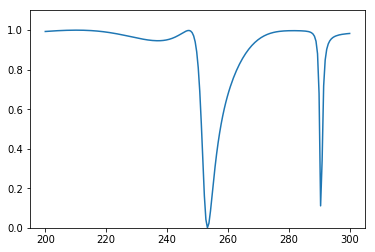

Test 21
True shape: [0.28531695 0.28887347 0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.30201375 0.28549588 0.2666567  0.21152356 0.20164028 0.19266409]]



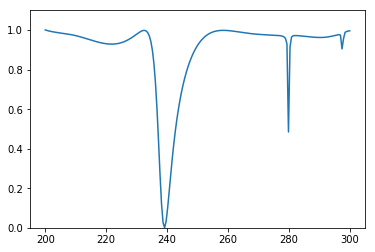

Test 22
True shape: [0.2 0.3 0.2 0.2 0.2 0.2]
Predicted shape: [[0.221578   0.29741603 0.2002942  0.21054238 0.18837425 0.22610699]]



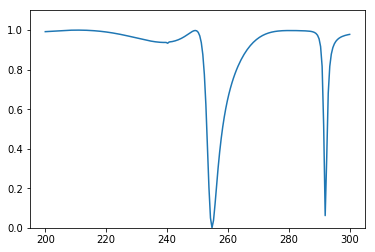

Test 23
True shape: [0.4      0.338636 0.3      0.3      0.2      0.1     ]
Predicted shape: [[0.39800122 0.36824852 0.28867683 0.20838276 0.2039217  0.21724437]]



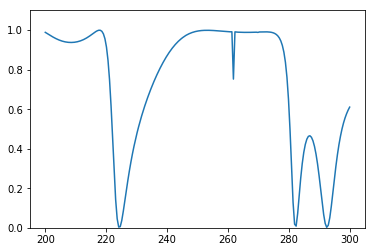

Test 24
True shape: [0.3 0.2 0.3 0.2 0.1 0.2]
Predicted shape: [[0.29836702 0.20976478 0.2928417  0.19277558 0.13537428 0.09786929]]



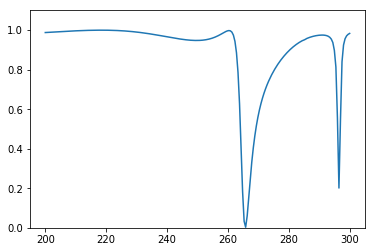

Test 25
True shape: [0.3        0.3        0.2        0.13169178 0.1        0.09876883]
Predicted shape: [[0.2996573  0.30093408 0.19768772 0.14243111 0.10301207 0.09439801]]



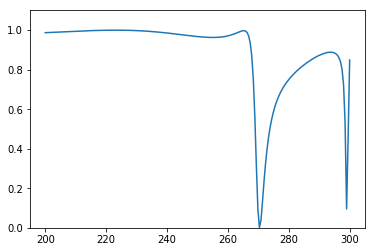

Test 26
True shape: [0.3 0.3 0.2 0.1 0.2 0.2]
Predicted shape: [[0.29700652 0.2972086  0.20162675 0.1082975  0.19248794 0.20156845]]



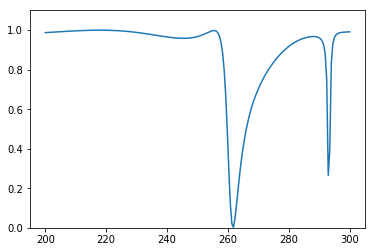

Test 27
True shape: [0.2 0.3 0.3 0.2 0.2 0.1]
Predicted shape: [[0.29951698 0.29525065 0.23371819 0.21260473 0.19474834 0.13020717]]



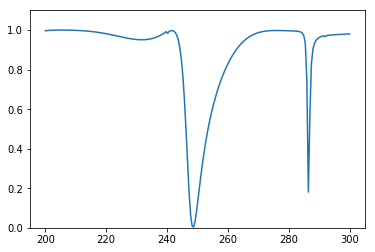

Test 28
True shape: [0.4 0.3 0.3 0.2 0.2 0.1]
Predicted shape: [[0.33051836 0.3056144  0.24204034 0.1996507  0.23673767 0.18020523]]



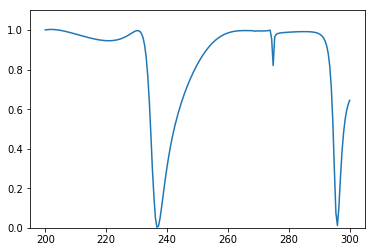

Test 29
True shape: [0.2       0.2       0.2370452 0.3       0.3       0.2      ]
Predicted shape: [[0.25267088 0.19625625 0.20930901 0.3027566  0.31396973 0.19905159]]



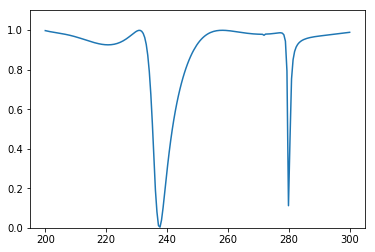

Test 30
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.1887995  0.19454351 0.19639659 0.3040447  0.19849588 0.20646617]]



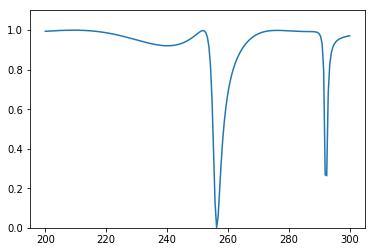

Test 31
True shape: [0.2963065  0.3        0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.2922576  0.29965678 0.20250142 0.12398127 0.13769057 0.11743309]]



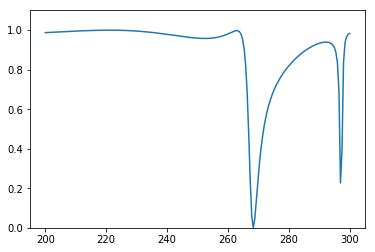

Test 32
True shape: [0.3        0.3        0.2        0.19507534 0.19507534 0.2       ]
Predicted shape: [[0.29697016 0.30039513 0.19800097 0.19925421 0.19544634 0.19816525]]



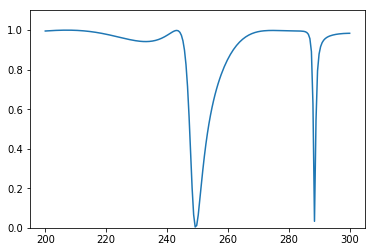

Test 33
True shape: [0.3        0.2        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.29927272 0.19807702 0.20012757 0.19801545 0.20407026 0.20001058]]



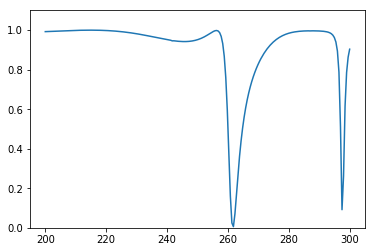

Test 34
True shape: [0.3       0.3       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.29038572 0.2976489  0.29323784 0.24475816 0.19375958 0.2953183 ]]



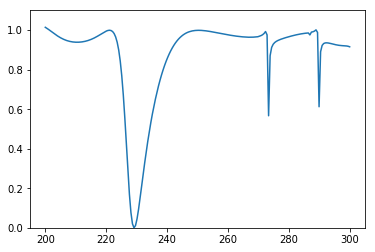

Test 35
True shape: [0.5        0.4        0.338636   0.3        0.2        0.19753767]
Predicted shape: [[0.49180084 0.4065496  0.34760022 0.3098155  0.21893604 0.21883479]]



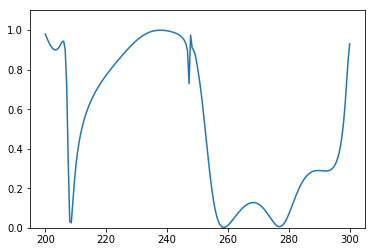

Test 36
True shape: [0.3        0.25051498 0.21968701 0.2        0.3        0.2       ]
Predicted shape: [[0.28904688 0.19885677 0.2335481  0.25374097 0.27054703 0.23519728]]



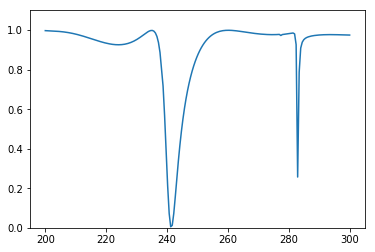

Test 37
True shape: [0.1        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.11018881 0.16538036 0.2055203  0.29683787 0.30222243 0.38469908]]



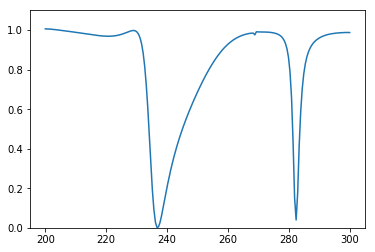

Test 38
True shape: [0.2       0.2       0.2370452 0.3       0.3       0.3      ]
Predicted shape: [[0.19919378 0.20684943 0.23745129 0.29796493 0.2959227  0.29564363]]



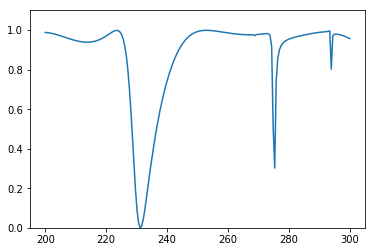

Test 39
True shape: [0.3        0.3        0.2370452  0.2        0.1        0.09876883]
Predicted shape: [[0.29760158 0.30242652 0.24041563 0.19839513 0.10293585 0.08821363]]



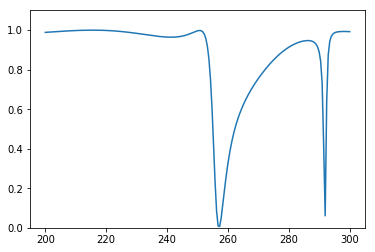

Test 40
True shape: [0.3        0.25051498 0.21968701 0.2        0.1        0.1       ]
Predicted shape: [[0.2992515  0.25200862 0.21712366 0.20172304 0.10202893 0.10610567]]



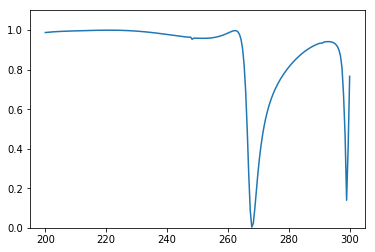

Test 41
True shape: [0.4        0.3        0.2        0.2        0.13169178 0.1       ]
Predicted shape: [[0.29001153 0.30240422 0.20928437 0.18949163 0.17135508 0.08910678]]



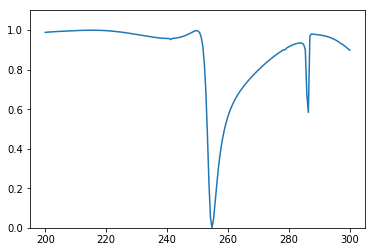

Test 42
True shape: [0.19753767 0.2        0.3        0.3        0.28887347 0.28531695]
Predicted shape: [[0.2521692  0.2503788  0.24319106 0.28968182 0.28324634 0.3049065 ]]



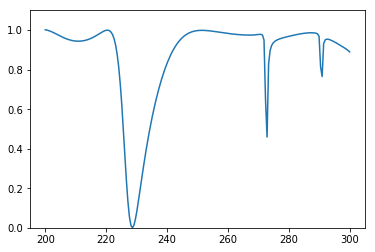

Test 43
True shape: [0.2 0.3 0.3 0.2 0.1 0.2]
Predicted shape: [[0.2977     0.2943173  0.23054996 0.2053748  0.15055004 0.13065875]]



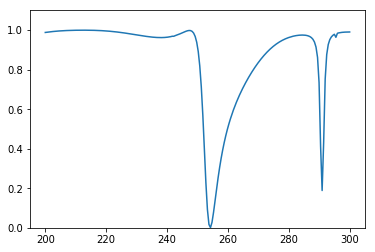

Test 44
True shape: [0.1        0.2        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.12191066 0.20156184 0.2188046  0.1970577  0.24662146 0.32106996]]



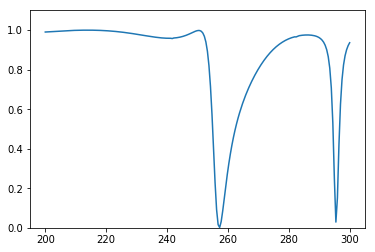

Test 45
True shape: [0.1        0.13169178 0.2        0.3        0.2370452  0.2       ]
Predicted shape: [[0.11653709 0.18500099 0.18166521 0.29154092 0.20664805 0.22376443]]



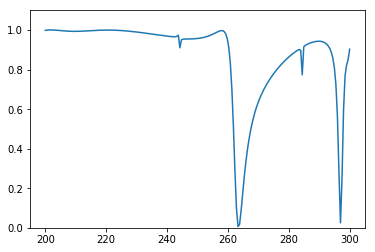

Test 46
True shape: [0.3        0.2370452  0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.2865479  0.20584008 0.19651857 0.24719578 0.20870511 0.12851751]]



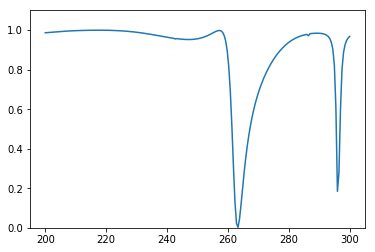

Test 47
True shape: [0.2 0.3 0.3 0.3 0.2 0.2]
Predicted shape: [[0.19519064 0.281145   0.3124862  0.2744996  0.22636478 0.23589619]]



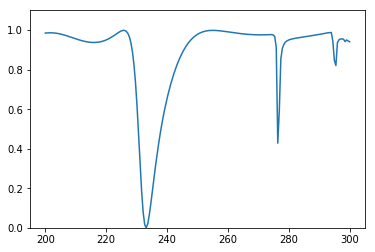

Test 48
True shape: [0.3       0.2       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.182636   0.3239872  0.2551418  0.19727814 0.2485044  0.23865938]]



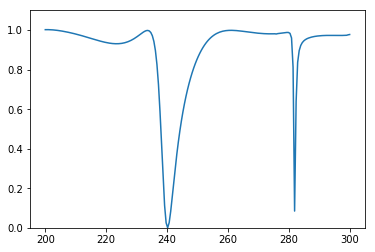

Test 49
True shape: [0.5       0.4389726 0.4       0.3       0.2963065 0.3      ]
Predicted shape: [[0.4974326  0.43930006 0.39860305 0.3001835  0.29112467 0.28961816]]



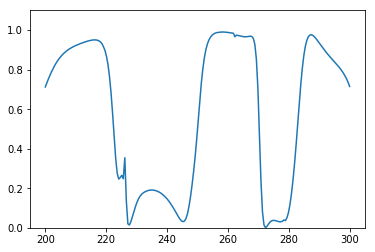

Test 50
True shape: [0.19753767 0.2        0.21968701 0.25051498 0.3        0.2       ]
Predicted shape: [[0.23656443 0.27840573 0.21905178 0.18035433 0.2764156  0.25349635]]



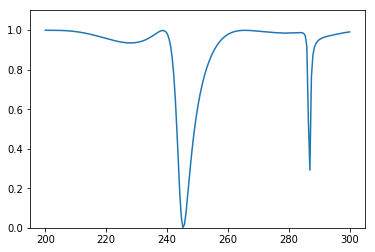

Test 51
True shape: [0.2 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.15805537 0.29058486 0.21633735 0.2167187  0.1913526  0.10997646]]



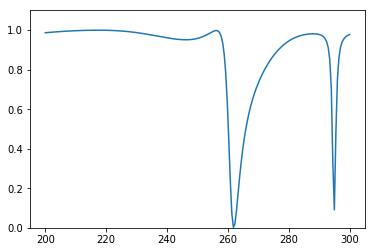

Test 52
True shape: [0.2        0.2        0.19753767 0.2        0.3        0.2963065 ]
Predicted shape: [[0.20173925 0.19320345 0.19632956 0.19908682 0.30486834 0.3026128 ]]



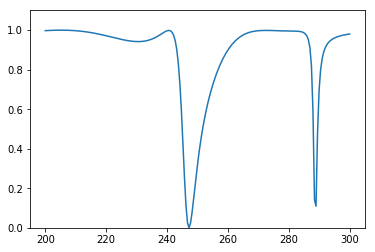

Test 53
True shape: [0.2       0.2       0.2       0.2       0.3       0.2963065]
Predicted shape: [[0.20208603 0.19518441 0.20040217 0.19810098 0.30299488 0.30178326]]



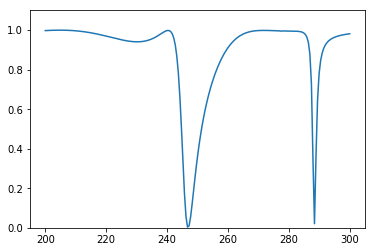

Test 54
True shape: [0.3        0.3        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.30965114 0.2708761  0.21466017 0.28852308 0.20786002 0.19612743]]



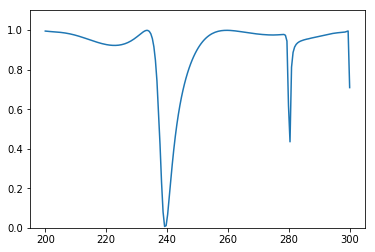

Test 55
True shape: [0.2       0.3       0.3       0.2963065 0.3       0.2      ]
Predicted shape: [[0.19267583 0.29476327 0.29342926 0.2980547  0.29602203 0.1966812 ]]



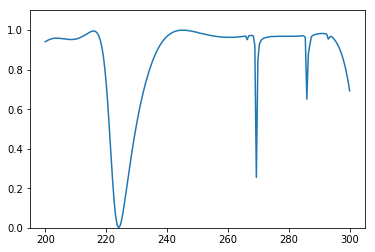

Test 56
True shape: [0.2963065  0.3        0.2        0.1        0.2        0.19753767]
Predicted shape: [[0.2858624  0.2988218  0.20187223 0.10278845 0.20862843 0.20315476]]



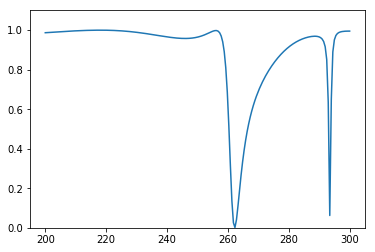

Test 57
True shape: [0.3        0.25051498 0.21968701 0.2        0.2        0.19753767]
Predicted shape: [[0.30043247 0.23384106 0.2429257  0.19970441 0.20200387 0.19465768]]



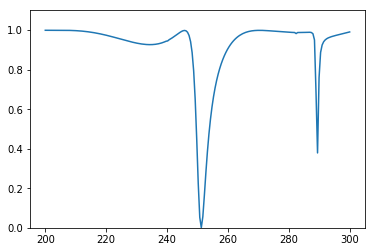

Test 58
True shape: [0.1        0.13169178 0.2        0.3        0.2963065  0.3       ]
Predicted shape: [[0.10468036 0.13537884 0.20365524 0.30236548 0.30201402 0.29719502]]



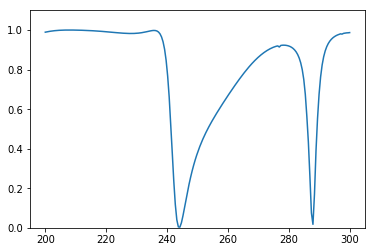

Test 59
True shape: [0.2       0.2       0.2370452 0.3       0.2370452 0.2      ]
Predicted shape: [[0.15597403 0.20413026 0.25191915 0.30697173 0.22581886 0.18982963]]



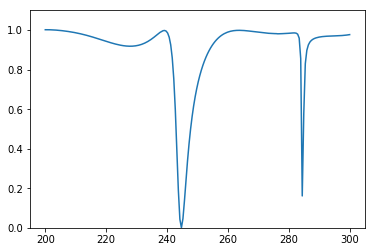

Test 60
True shape: [0.1       0.2       0.2370452 0.3       0.2       0.1      ]
Predicted shape: [[0.13986969 0.21330884 0.3076954  0.2450997  0.18190414 0.09493477]]



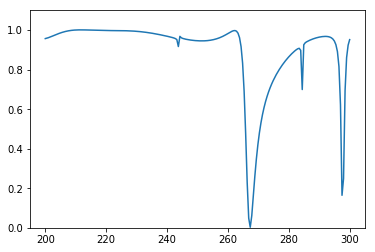

Test 61
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.19753767]
Predicted shape: [[0.20017621 0.21446747 0.27734774 0.26168677 0.22322704 0.20607649]]



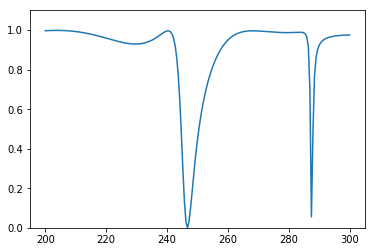

Test 62
True shape: [0.3        0.2        0.19507534 0.19507534 0.2        0.2       ]
Predicted shape: [[0.30091465 0.19975013 0.1962204  0.19784394 0.19977698 0.2014574 ]]



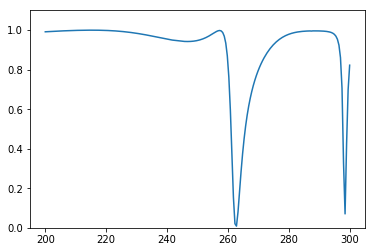

Test 63
True shape: [0.2        0.2        0.2370452  0.3        0.28887347 0.28531695]
Predicted shape: [[0.19996405 0.2821784  0.21374223 0.24233273 0.30476987 0.28688377]]



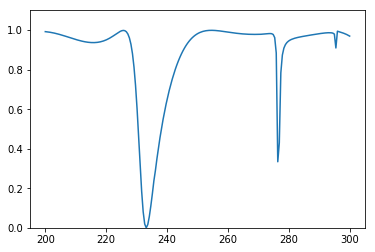

Test 64
True shape: [0.3       0.3       0.3       0.2       0.2370452 0.3      ]
Predicted shape: [[0.29860595 0.2979461  0.29957557 0.22941428 0.20934199 0.29229218]]



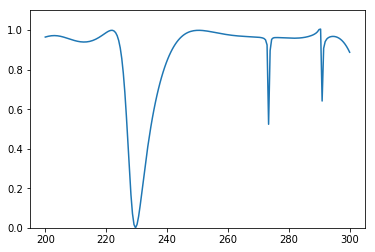

Test 65
True shape: [0.3       0.2       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.20936733 0.19992197 0.28903022 0.3167163  0.29328948 0.20247595]]



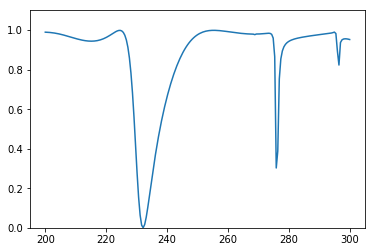

Test 66
True shape: [0.2 0.1 0.2 0.3 0.3 0.3]
Predicted shape: [[0.17778397 0.12098917 0.20852816 0.30373016 0.3033859  0.27949214]]



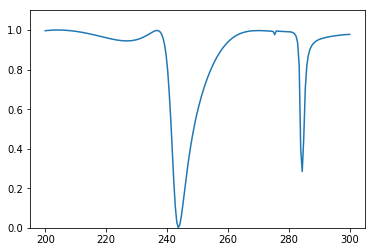

Test 67
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.2        0.3       ]
Predicted shape: [[0.27888614 0.28578043 0.30404633 0.22860432 0.24700594 0.22232395]]



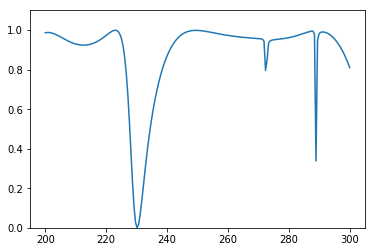

Test 68
True shape: [0.2       0.2       0.3       0.2963065 0.3       0.2963065]
Predicted shape: [[0.24639419 0.27959353 0.24429181 0.26699156 0.31783906 0.27308232]]



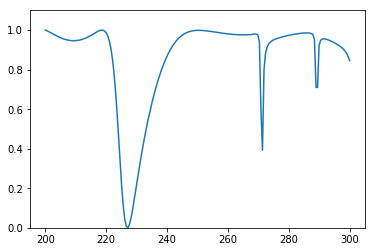

Test 69
True shape: [0.3      0.292613 0.292613 0.3      0.2      0.1     ]
Predicted shape: [[0.30774152 0.30580392 0.29079545 0.3108062  0.20904925 0.14275886]]



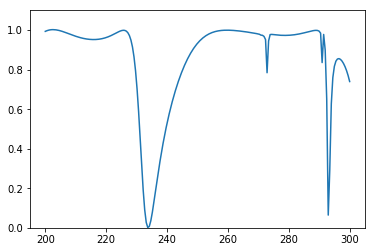

Test 70
True shape: [0.3        0.2        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.30526495 0.20150095 0.28987408 0.29601535 0.2030341  0.19697466]]



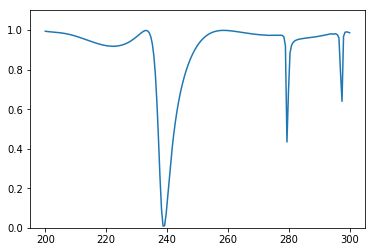

Test 71
True shape: [0.1902113  0.19258231 0.2        0.2370452  0.3        0.2963065 ]
Predicted shape: [[0.20893392 0.21995872 0.19380918 0.2307514  0.2922609  0.2958938 ]]



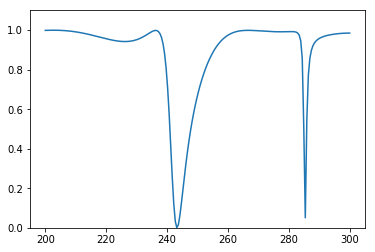

Test 72
True shape: [0.3 0.3 0.2 0.2 0.3 0.3]
Predicted shape: [[0.2835754  0.30625057 0.19411829 0.20632577 0.30049658 0.28160167]]



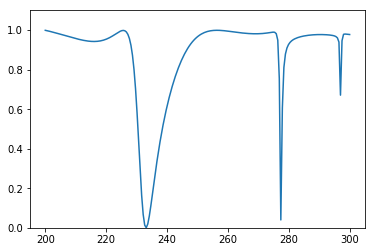

Test 73
True shape: [0.2 0.2 0.2 0.3 0.3 0.2]
Predicted shape: [[0.20159173 0.19916046 0.19316697 0.2971314  0.30591387 0.19443938]]



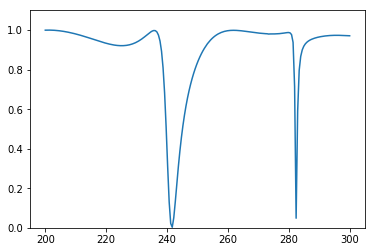

Test 74
True shape: [0.2       0.2       0.3       0.3       0.2963065 0.3      ]
Predicted shape: [[0.23906645 0.2778352  0.26247576 0.2414163  0.32313207 0.27667165]]



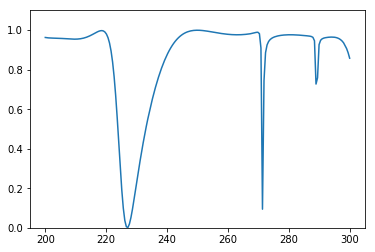

Test 75
True shape: [0.3        0.4        0.5        0.4        0.5        0.49384417]
Predicted shape: [[0.3045243  0.4043257  0.49795175 0.39946592 0.49887222 0.5009822 ]]



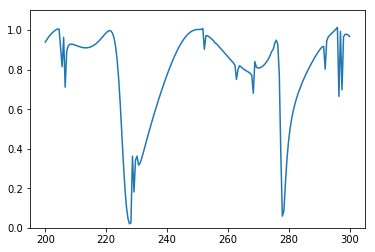

Test 76
True shape: [0.1 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.11272404 0.16377911 0.2018227  0.3066908  0.3024623  0.3973333 ]]



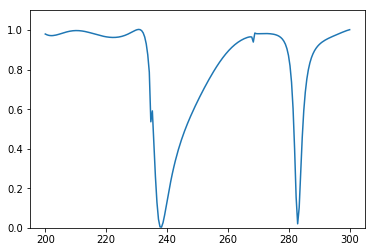

Test 77
True shape: [0.1       0.2       0.2370452 0.3       0.2963065 0.3      ]
Predicted shape: [[0.09956011 0.20532829 0.22264162 0.30052727 0.29788828 0.3113178 ]]



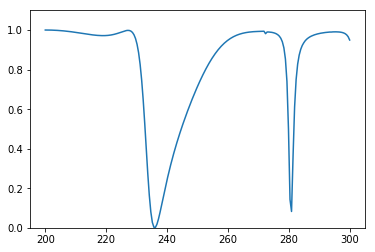

Test 78
True shape: [0.3        0.3        0.25606269 0.22825356 0.21057    0.2       ]
Predicted shape: [[0.27146003 0.28529778 0.29215166 0.2278364  0.20080723 0.2251178 ]]



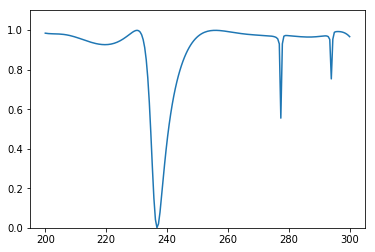

Test 79
True shape: [0.19753767 0.2        0.2370452  0.3        0.3        0.3       ]
Predicted shape: [[0.20086738 0.20131382 0.23390928 0.29890588 0.2995464  0.29633293]]



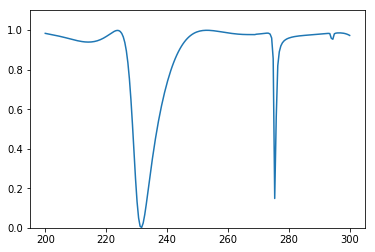

Test 80
True shape: [0.3        0.3        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.22155586 0.27892908 0.2875238  0.31117785 0.22066078 0.17375262]]



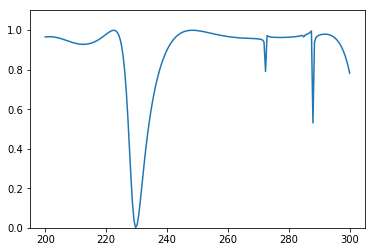

Test 81
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.1       ]
Predicted shape: [[0.19120607 0.18014231 0.19598088 0.2972657  0.2106072  0.10249497]]



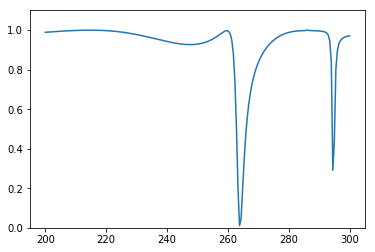

Test 82
True shape: [0.09876883 0.1        0.2        0.2370452  0.3        0.3       ]
Predicted shape: [[0.09258291 0.10241774 0.19772047 0.23341748 0.30442291 0.3087916 ]]



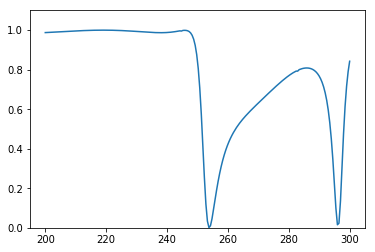

Test 83
True shape: [0.09876883 0.1        0.2        0.3        0.2963065  0.3       ]
Predicted shape: [[0.08647308 0.09936446 0.20015764 0.30049407 0.29843107 0.29207602]]



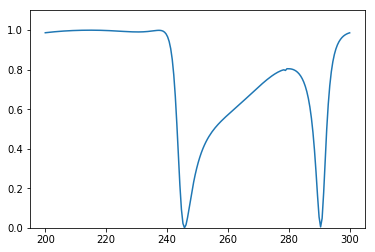

Test 84
True shape: [0.3        0.3        0.4        0.5        0.4        0.39507534]
Predicted shape: [[0.29861116 0.3161145  0.38531262 0.4825519  0.3980902  0.39054295]]



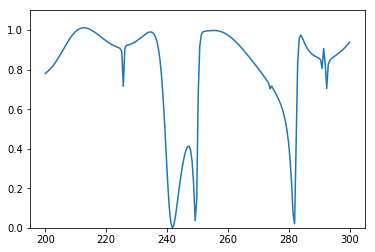

Test 85
True shape: [0.3       0.2370452 0.2       0.2       0.3       0.4      ]
Predicted shape: [[0.1911006  0.2862027  0.2824342  0.23238361 0.2569321  0.26734993]]



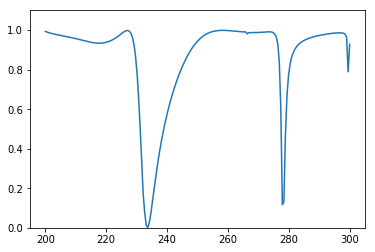

Test 86
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.1       ]
Predicted shape: [[0.2015687  0.21894431 0.2385023  0.22835147 0.21797346 0.17374003]]



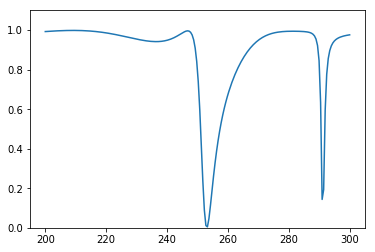

Test 87
True shape: [0.2        0.2370452  0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.19194451 0.23613167 0.2974847  0.20203504 0.20079996 0.21162106]]



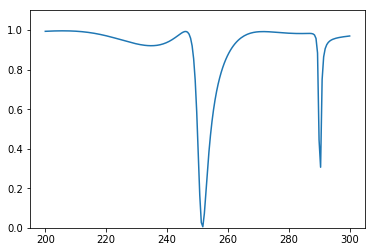

Test 88
True shape: [0.3 0.2 0.2 0.2 0.3 0.4]
Predicted shape: [[0.1804865  0.1755451  0.20066094 0.24101454 0.31129128 0.41321328]]



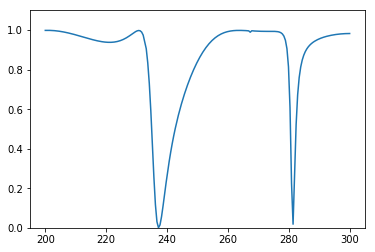

Test 89
True shape: [0.2       0.2       0.3       0.2963065 0.3       0.2      ]
Predicted shape: [[0.20122358 0.20455313 0.30854672 0.30385125 0.29663807 0.19608307]]



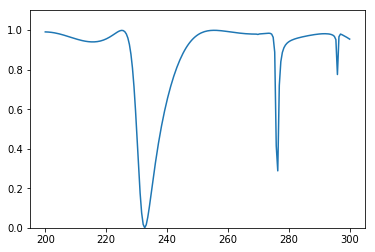

Test 90
True shape: [0.3       0.2       0.2       0.2       0.2370452 0.3      ]
Predicted shape: [[0.2932194  0.20296085 0.19543344 0.20114845 0.23838459 0.30055425]]



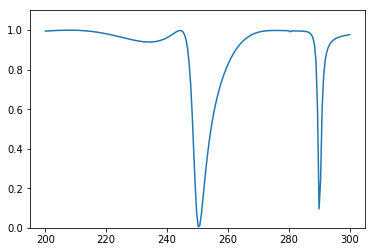

Test 91
True shape: [0.2        0.2        0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.18968847 0.2026478  0.2904191  0.21323338 0.19959311 0.17461152]]



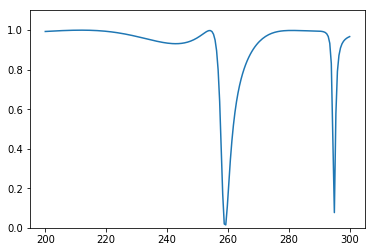

Test 92
True shape: [0.2 0.2 0.1 0.2 0.3 0.3]
Predicted shape: [[0.19290137 0.18642816 0.10402775 0.1959039  0.3086826  0.31039906]]



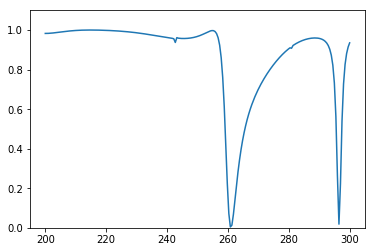

Test 93
True shape: [0.3 0.2 0.2 0.3 0.2 0.1]
Predicted shape: [[0.25993222 0.2694187  0.19949618 0.23113772 0.20223282 0.15618087]]



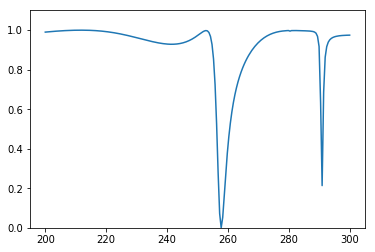

Test 94
True shape: [0.2        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.26172698 0.21626917 0.22799963 0.26482671 0.20777549 0.1995212 ]]



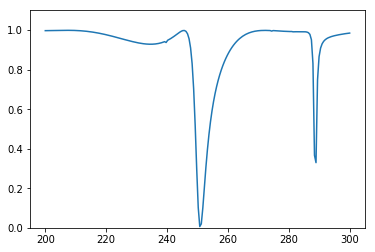

Test 95
True shape: [0.3       0.2370452 0.2       0.3       0.2       0.1      ]
Predicted shape: [[0.19479638 0.26200444 0.19707328 0.28688335 0.212311   0.11992396]]



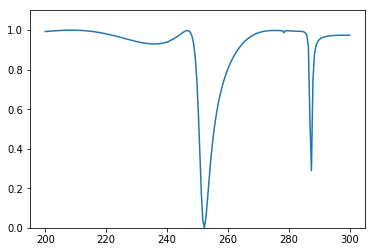

Test 96
True shape: [0.3        0.2        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.27636504 0.19755584 0.19276452 0.3092179  0.20067103 0.1920985 ]]



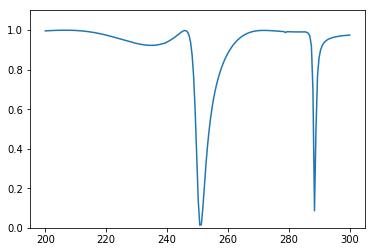

Test 97
True shape: [0.3        0.2        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.18297756 0.20990217 0.30835897 0.19885367 0.23309238 0.27988073]]



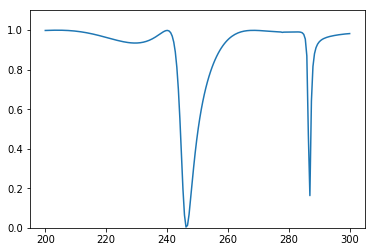

Test 98
True shape: [0.2        0.13169178 0.1        0.2        0.3        0.4       ]
Predicted shape: [[0.190635   0.11981708 0.1326657  0.2116405  0.30575773 0.399715  ]]



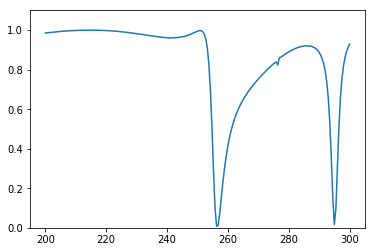

Test 99
True shape: [0.3       0.2       0.2       0.2370452 0.3       0.2963065]
Predicted shape: [[0.28893918 0.20776376 0.19865078 0.2409521  0.30606246 0.29333302]]



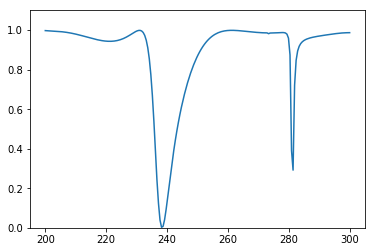

Test 100
True shape: [0.3       0.2370452 0.2       0.3       0.3       0.2      ]
Predicted shape: [[0.25928694 0.25691688 0.21554312 0.24985594 0.2956669  0.2739306 ]]



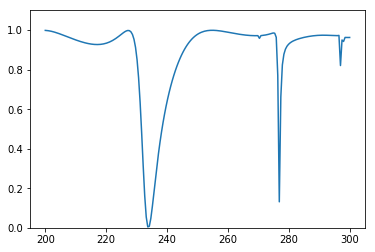

Test 101
True shape: [0.19753767 0.2        0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.1874676  0.1912669  0.19899589 0.20676956 0.30229953 0.19528595]]



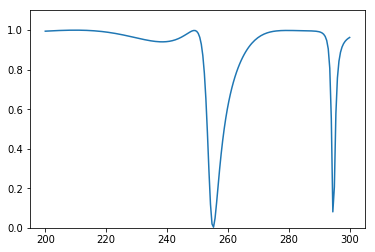

Test 102
True shape: [0.09876883 0.1        0.2        0.2370452  0.3        0.2963065 ]
Predicted shape: [[0.09362459 0.10071015 0.1976169  0.22959304 0.302444   0.31393278]]



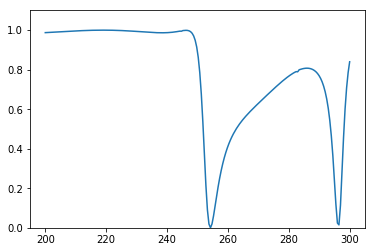

Test 103
True shape: [0.2        0.2        0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.19044346 0.20874104 0.30267763 0.2928179  0.2588562  0.23790427]]



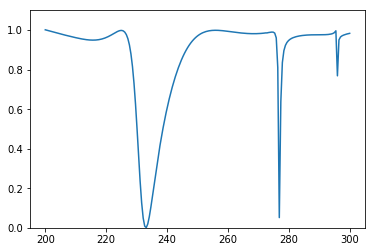

Test 104
True shape: [0.2963065 0.3       0.3       0.2       0.3       0.2      ]
Predicted shape: [[0.29176956 0.30203536 0.28812325 0.20538303 0.28956398 0.2223328 ]]



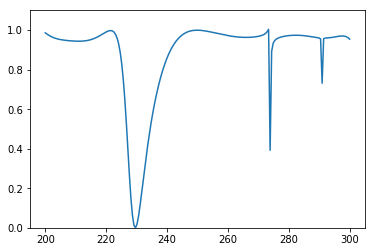

Test 105
True shape: [0.1       0.2       0.2370452 0.3       0.3       0.2963065]
Predicted shape: [[0.0994947  0.20612091 0.23305187 0.30059928 0.29931992 0.2978386 ]]



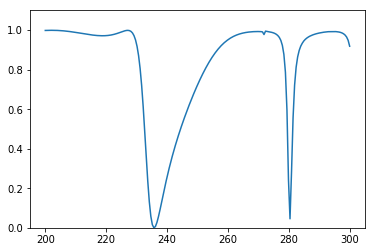

Test 106
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.3       ]
Predicted shape: [[0.19170764 0.16919109 0.20428967 0.2687648  0.29375455 0.38351122]]



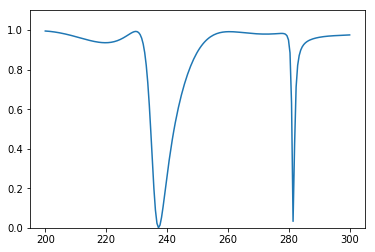

Test 107
True shape: [0.2963065 0.3       0.3       0.2       0.2       0.1      ]
Predicted shape: [[0.3020512  0.30043614 0.29857022 0.19791767 0.20453618 0.10374865]]



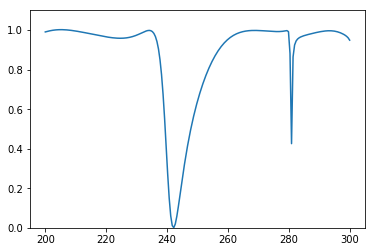

Test 108
True shape: [0.2        0.21057    0.22825356 0.25606269 0.3        0.4       ]
Predicted shape: [[0.19261035 0.19713673 0.2193169  0.29623407 0.30299482 0.39128736]]



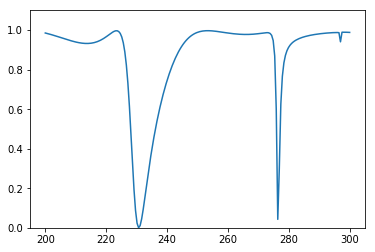

Test 109
True shape: [0.2        0.1        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.20115861 0.10800347 0.21446994 0.26123038 0.27257338 0.18170527]]



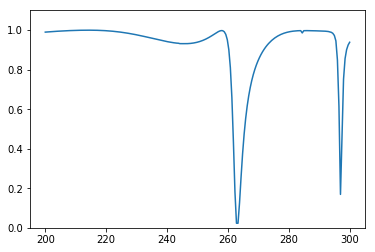

Test 110
True shape: [0.5       0.4389726 0.4       0.3       0.3       0.3      ]
Predicted shape: [[0.4909581  0.4355282  0.39119774 0.3061158  0.28391403 0.2801365 ]]



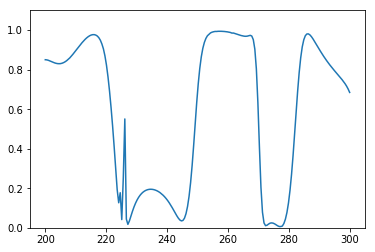

Test 111
True shape: [0.3 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.24250266 0.24557707 0.25717503 0.20249945 0.31748047 0.39545488]]



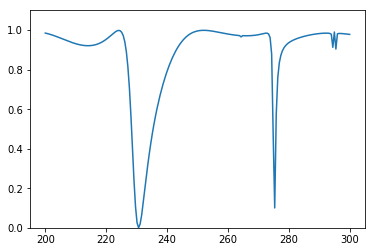

Test 112
True shape: [0.2        0.19753767 0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.1930153  0.19823858 0.19780815 0.20491812 0.2999985  0.19998483]]



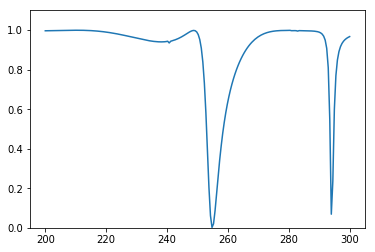

Test 113
True shape: [0.2        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.2015686  0.29598296 0.19581255 0.19844747 0.19891135 0.21586877]]



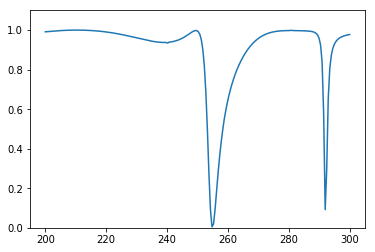

Test 114
True shape: [0.2       0.2370452 0.3       0.2       0.3       0.2963065]
Predicted shape: [[0.19755173 0.2227659  0.29058054 0.23116744 0.29859614 0.29172406]]



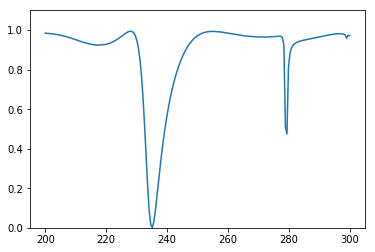

Test 115
True shape: [0.19753767 0.2        0.3        0.2963065  0.3        0.2       ]
Predicted shape: [[0.1792402  0.24150017 0.27324188 0.26835102 0.2917768  0.24084024]]



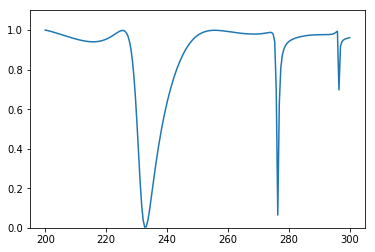

Test 116
True shape: [0.3 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.2836343  0.28222728 0.22833648 0.19768506 0.17145978 0.10052347]]



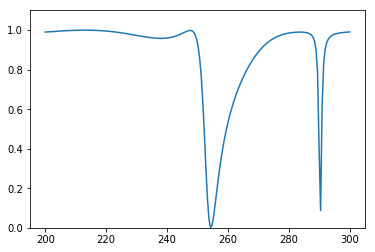

Test 117
True shape: [0.2963065  0.3        0.2        0.13169178 0.1        0.1       ]
Predicted shape: [[0.2986827  0.2993976  0.19776407 0.14264998 0.09833366 0.09731872]]



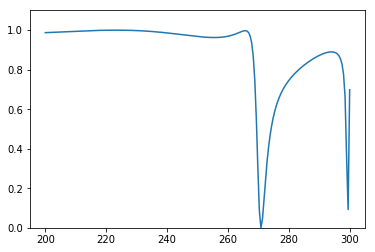

Test 118
True shape: [0.3        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.30229396 0.3000614  0.19596443 0.20195878 0.19836879 0.20094934]]



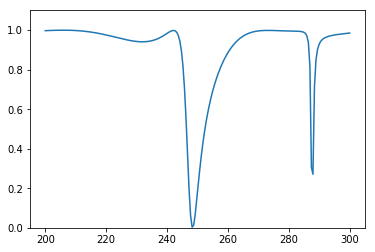

Test 119
True shape: [0.2       0.3       0.2370452 0.2       0.2       0.1      ]
Predicted shape: [[0.30586255 0.30641443 0.19394305 0.17731422 0.1932004  0.14509508]]



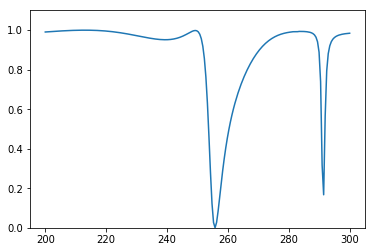

Test 120
True shape: [0.4        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.39514655 0.29580083 0.2425951  0.20145255 0.20081425 0.1913192 ]]



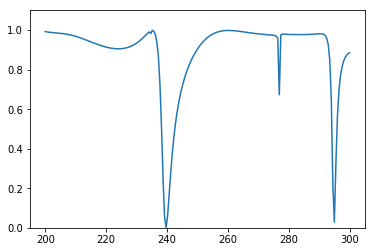

Test 121
True shape: [0.2        0.3        0.25606269 0.22825356 0.21057    0.2       ]
Predicted shape: [[0.1663577  0.21011081 0.2768029  0.3226505  0.2746971  0.23243995]]



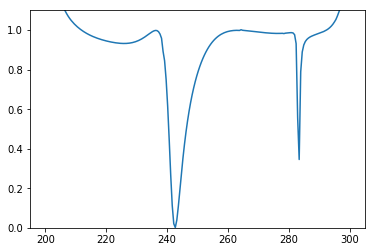

Test 122
True shape: [0.2963065 0.3       0.2       0.2       0.3       0.2      ]
Predicted shape: [[0.29220742 0.30450666 0.2002286  0.20180586 0.30433968 0.20510364]]



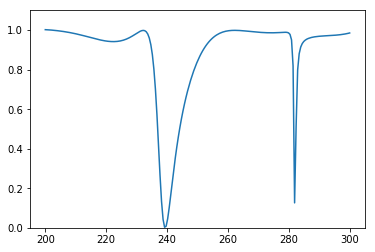

Test 123
True shape: [0.1       0.1       0.2       0.2370452 0.3       0.4      ]
Predicted shape: [[0.0949038  0.11721084 0.19884953 0.2663057  0.2950775  0.363037  ]]



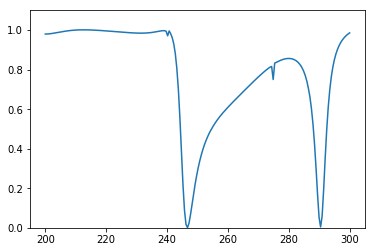

Test 124
True shape: [0.3       0.2370452 0.2       0.3       0.3       0.2963065]
Predicted shape: [[0.3088441  0.26607412 0.2017977  0.29918623 0.2987076  0.2784671 ]]



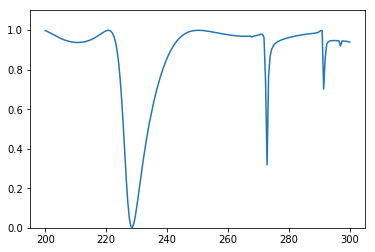

Test 125
True shape: [0.1 0.1 0.2 0.3 0.3 0.4]
Predicted shape: [[0.11024299 0.12559864 0.19863534 0.30271596 0.30434197 0.4113626 ]]



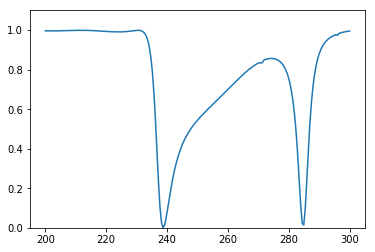

Test 126
True shape: [0.3        0.2        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.29847482 0.19748965 0.20227212 0.1977635  0.2063159  0.19969158]]



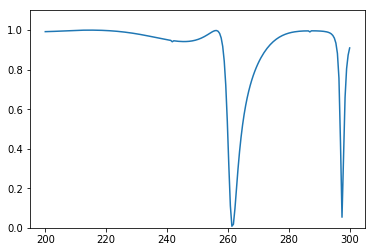

Test 127
True shape: [0.3        0.25051498 0.21968701 0.2        0.2        0.1       ]
Predicted shape: [[0.182859   0.19840488 0.30564928 0.23148581 0.20527172 0.09141523]]



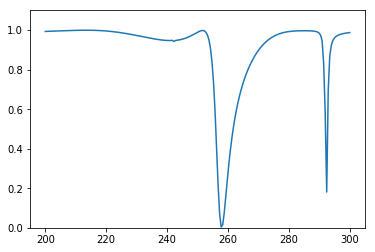

Test 128
True shape: [0.2 0.3 0.3 0.2 0.1 0.1]
Predicted shape: [[0.19899425 0.3018151  0.2978199  0.19869718 0.10383325 0.10386095]]



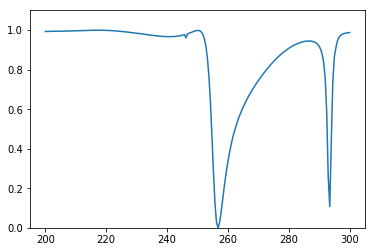

Test 129
True shape: [0.2 0.3 0.3 0.2 0.2 0.2]
Predicted shape: [[0.20122883 0.29808533 0.2964769  0.18614998 0.20700869 0.21617123]]



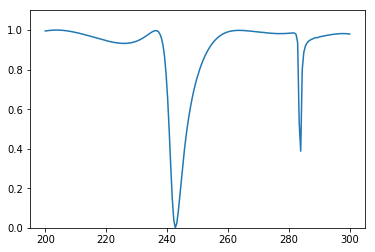

Test 130
True shape: [0.2        0.3        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.19835249 0.28361762 0.31339964 0.27040452 0.22308606 0.23870817]]



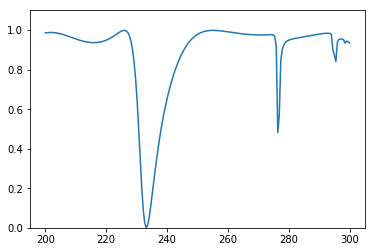

Test 131
True shape: [0.2427051  0.24573045 0.25519524 0.2723943  0.3        0.2       ]
Predicted shape: [[0.17388886 0.25407538 0.2664438  0.2645812  0.27422577 0.26613805]]



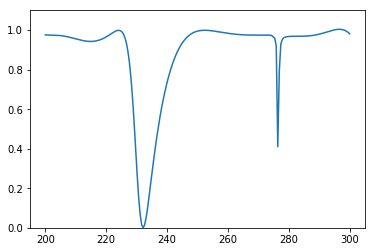

Test 132
True shape: [0.2 0.3 0.2 0.2 0.1 0.2]
Predicted shape: [[0.2778358  0.300158   0.20577303 0.12823057 0.15412356 0.14373417]]



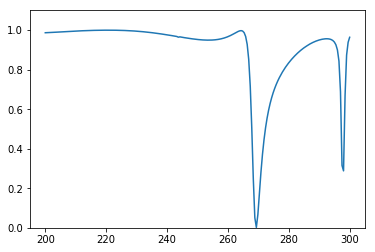

Test 133
True shape: [0.19753767 0.2        0.3        0.2        0.2370452  0.3       ]
Predicted shape: [[0.23107141 0.2077584  0.2573629  0.20386863 0.29280072 0.2297577 ]]



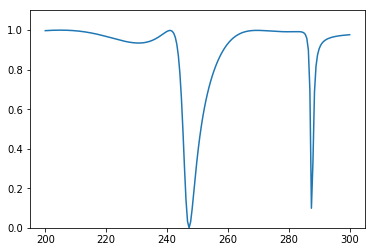

Test 134
True shape: [0.2 0.3 0.3 0.2 0.3 0.3]
Predicted shape: [[0.20699543 0.3015456  0.29730994 0.19662964 0.29574615 0.30477768]]



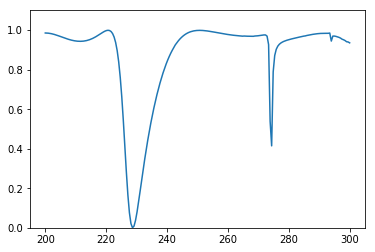

Test 135
True shape: [0.2963065  0.3        0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.2975969  0.30149612 0.19538999 0.20785555 0.10484643 0.10505833]]



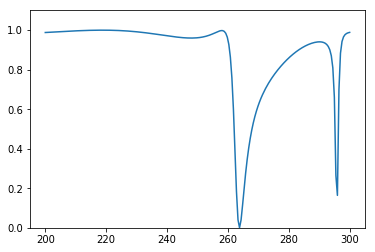

Test 136
True shape: [0.2 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.20867628 0.26399308 0.26542908 0.28328404 0.22752894 0.2839386 ]]



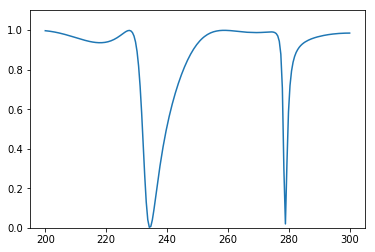

Test 137
True shape: [0.19753767 0.2        0.3        0.2        0.3        0.4       ]
Predicted shape: [[0.20995384 0.25667024 0.25656828 0.2869746  0.24003789 0.285991  ]]



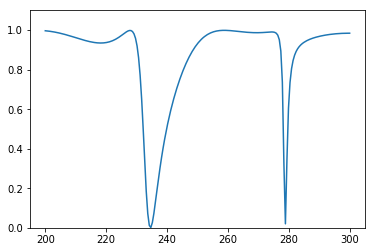

Test 138
True shape: [0.19753767 0.2        0.2        0.3        0.2        0.3       ]
Predicted shape: [[0.2051844  0.19682044 0.19052991 0.30724585 0.1989879  0.28366646]]



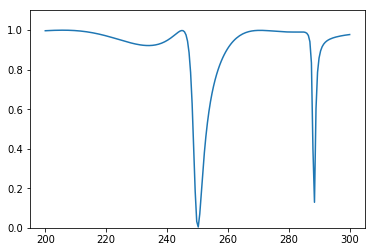

Test 139
True shape: [0.2        0.3        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.29878047 0.30462724 0.19773242 0.10187808 0.20201544 0.30079624]]



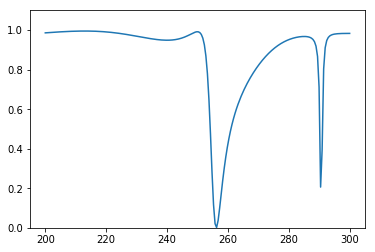

Test 140
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.2       ]
Predicted shape: [[0.18850625 0.19453791 0.19873157 0.30120853 0.19922431 0.2078671 ]]



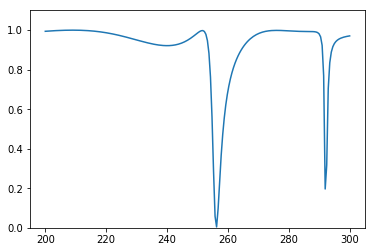

Test 141
True shape: [0.3       0.3       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.2406874  0.30744898 0.24069563 0.2969275  0.30052465 0.23228051]]



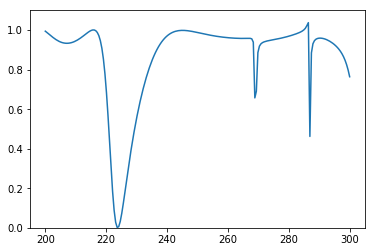

Test 142
True shape: [0.1 0.2 0.3 0.3 0.2 0.3]
Predicted shape: [[0.08577386 0.18949363 0.25373426 0.28454998 0.2680574  0.2459284 ]]



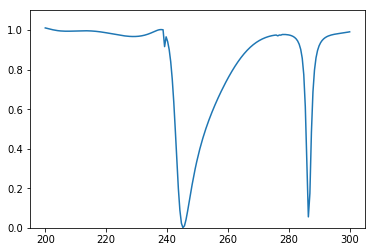

Test 143
True shape: [0.2       0.2370452 0.3       0.3       0.3       0.2      ]
Predicted shape: [[0.20265189 0.22617033 0.27879274 0.30052906 0.3051664  0.23562182]]



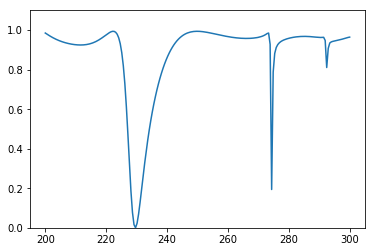

Test 144
True shape: [0.2 0.2 0.3 0.3 0.2 0.1]
Predicted shape: [[0.18155956 0.21341795 0.28896287 0.2790938  0.2100687  0.12142465]]



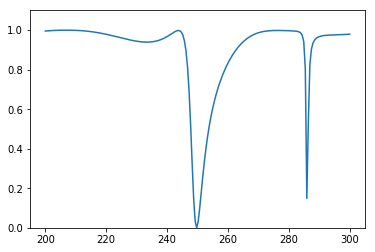

Test 145
True shape: [0.3        0.2370452  0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.29919457 0.23315874 0.19955915 0.19671619 0.20220892 0.20051143]]



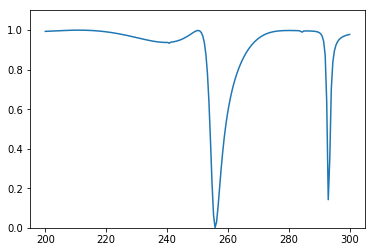

Test 146
True shape: [0.3       0.2370452 0.2       0.3       0.2       0.2      ]
Predicted shape: [[0.2938413  0.21799496 0.19911337 0.29704183 0.2157087  0.20283711]]



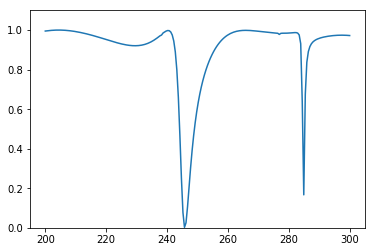

Test 147
True shape: [0.1902113  0.19258231 0.2        0.3        0.2        0.3       ]
Predicted shape: [[0.17460576 0.21286285 0.20343673 0.21218807 0.26254895 0.30404466]]



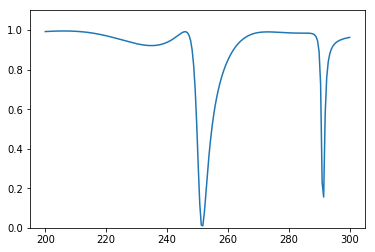

Test 148
True shape: [0.2       0.2       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.1972785  0.20172733 0.19916752 0.29934126 0.30013183 0.29879692]]



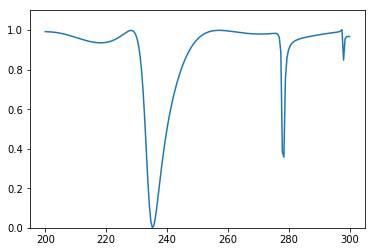

Test 149
True shape: [0.2        0.21968701 0.25051498 0.3        0.2        0.3       ]
Predicted shape: [[0.18742162 0.23862138 0.2974542  0.21959165 0.22414707 0.27229366]]



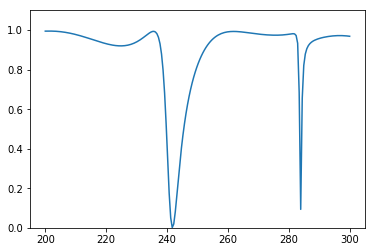

Test 150
True shape: [0.2        0.2370452  0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.21041363 0.2399984  0.28423738 0.190799   0.19254336 0.21513364]]



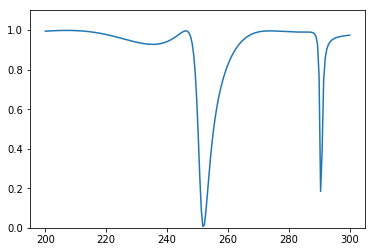

Test 151
True shape: [0.2963065  0.3        0.25051498 0.21968701 0.2        0.1       ]
Predicted shape: [[0.29553682 0.30298167 0.25238463 0.22370556 0.21347627 0.09904551]]



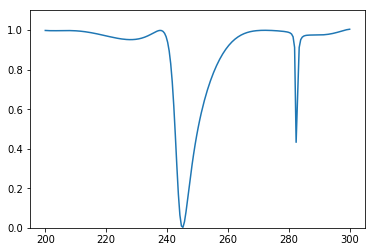

Test 152
True shape: [0.3 0.2 0.3 0.2 0.2 0.1]
Predicted shape: [[0.17894387 0.19399035 0.3171029  0.23611644 0.20270911 0.085475  ]]



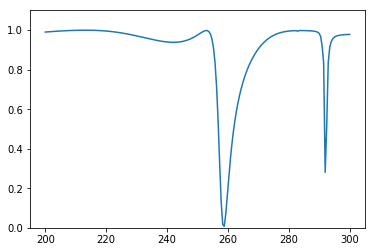

Test 153
True shape: [0.2963065 0.3       0.2       0.2       0.2       0.1      ]
Predicted shape: [[0.29472417 0.29201335 0.20075029 0.199465   0.19943798 0.10318372]]



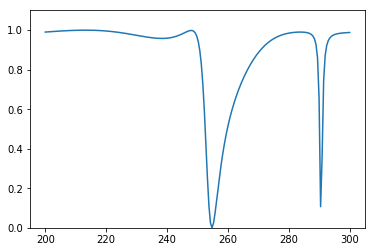

Test 154
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.1      ]
Predicted shape: [[0.22918493 0.21437192 0.2440756  0.29029292 0.21220224 0.14621669]]



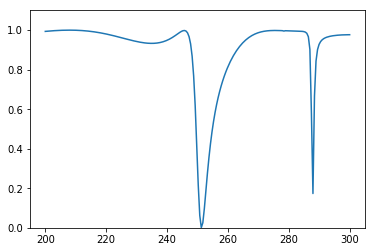

Test 155
True shape: [0.2        0.2        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.29432076 0.2234514  0.2359173  0.21284786 0.21527117 0.2801593 ]]



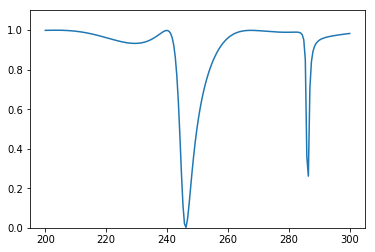

Test 156
True shape: [0.3        0.25051498 0.21968701 0.2        0.19753767 0.2       ]
Predicted shape: [[0.30384883 0.22049072 0.26827615 0.19807047 0.20126323 0.19419147]]



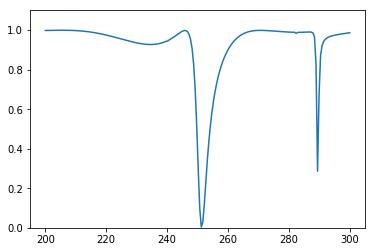

Test 157
True shape: [0.1       0.2       0.3       0.2       0.2370452 0.3      ]
Predicted shape: [[0.09864315 0.20153192 0.29565927 0.22151405 0.21615228 0.29993445]]



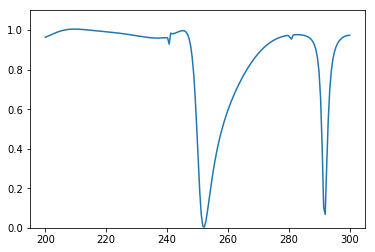

Test 158
True shape: [0.1       0.1       0.2       0.3       0.2963065 0.3      ]
Predicted shape: [[0.0993776  0.10759792 0.195759   0.30168688 0.29603237 0.28986788]]



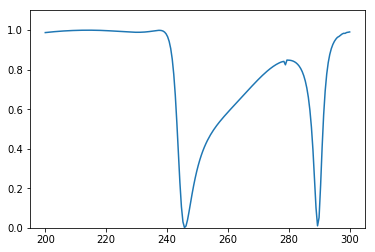

Test 159
True shape: [0.19753767 0.2        0.19753767 0.2        0.2        0.3       ]
Predicted shape: [[0.19308639 0.1990141  0.20123205 0.19661859 0.20009273 0.30431855]]



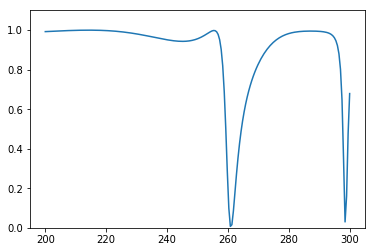

Test 160
True shape: [0.2       0.2       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.19655329 0.17634693 0.26542026 0.25386354 0.23440297 0.3148247 ]]



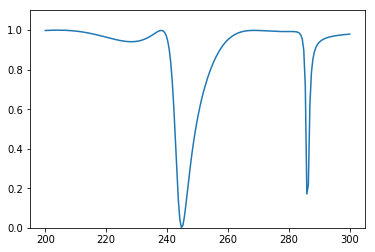

Test 161
True shape: [0.3        0.2370452  0.2        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.25726086 0.20769173 0.22447559 0.1927846  0.22261047 0.20667928]]



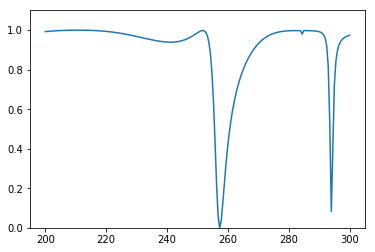

Test 162
True shape: [0.19753767 0.2        0.3        0.2        0.2        0.2       ]
Predicted shape: [[0.19320792 0.2033341  0.29720733 0.2050941  0.19963773 0.19531316]]



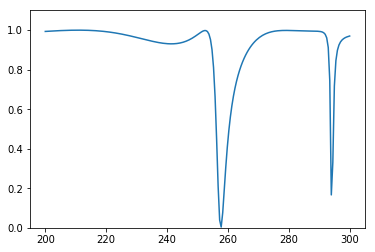

Test 163
True shape: [0.2       0.2       0.3       0.3       0.2370452 0.2      ]
Predicted shape: [[0.19579747 0.2107721  0.29943693 0.30238563 0.22940157 0.20273347]]



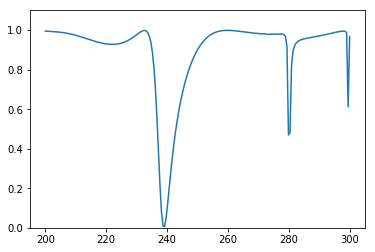

Test 164
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.2       ]
Predicted shape: [[0.18468696 0.1964516  0.24935877 0.31850013 0.21511634 0.26444453]]



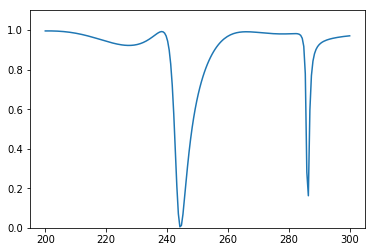

Test 165
True shape: [0.3       0.3       0.2963065 0.3       0.3       0.4      ]
Predicted shape: [[0.28494757 0.29821974 0.30080074 0.29397988 0.30180183 0.3852658 ]]



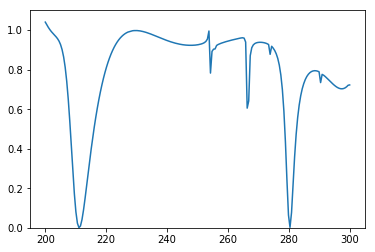

Test 166
True shape: [0.09876883 0.1        0.2        0.3        0.4        0.3       ]
Predicted shape: [[0.10205138 0.09824595 0.19450915 0.29535174 0.34953308 0.40030622]]



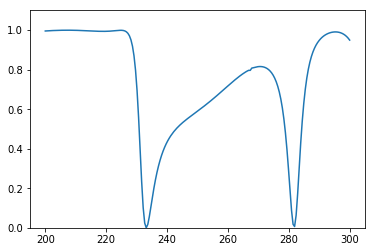

Test 167
True shape: [0.2        0.2        0.21057    0.22825356 0.25606269 0.3       ]
Predicted shape: [[0.23178762 0.2534671  0.20548895 0.20627832 0.25767773 0.21254218]]



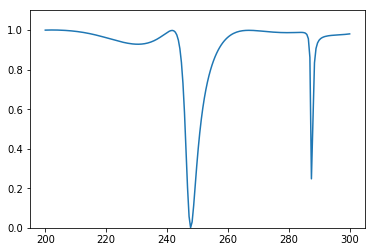

In [17]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))